In [1]:
import os, random, numpy as np
import pandas as pd
from pathlib import Path
import shutil
from questionnaire_functions import (export_questionnaire,export_questionnaire,analyze_questionnaire)
from pca_functions import (find_optimal_pca_dimensions,plot_pca_weights_two_cols_split,plot_pca_weights_separate_and_table)
from clustring_functions import(pca_kmeans_minimal_outputs,run_kmeans_clustering,invert_binary_columns,gap_statistic)
from vizualizations_functions import (plot_grouped_bars,plot_multi_dataset_scatters_colored,plot_one_period_with_labels,get_labels_from_file,plot_one_period_with_labels_and_ttest,
                                      plot_subject_trajectories,stats_by_group,safe)
from preprocessing_functions import (load_one,transition_for_pair)
from functools import reduce
import textwrap
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import ttest_rel



In [2]:
SEED = 17
os.environ["PYTHONHASHSEED"] = str(SEED)

# לכבות רנדומליות בספריות BLAS/OMP
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

random.seed(SEED)
np.random.seed(SEED)

print("Seed fixed:", SEED)

Seed fixed: 17


## preapering the data

In [3]:


file_path = 'data/q_data/Study_Questionnaire_Responses_October.xlsx'
columns_to_select = ["Subject_Code", "b_questionnaire_completion", "after_questionnaire_completion", "t1_MAAS_date",
                         "t2_PHQ_date", "t3_MAAS_date"]

df = pd.read_excel(file_path)
columns = df.columns.tolist()
print("the columns in the dataframe:")
for col in columns:
    print(col)

selected_df = df.loc[:, columns_to_select]

print("DataFrame with selected columns")
print(f"lines: {selected_df .shape[0]}, columns: {selected_df .shape[1]}")


print("\nהצגת ה-DataFrame החדש (5 השורות הראשונות):")
print(selected_df.head())


the columns in the dataframe:
study_id
Subject_Code
diamond_interview_date
b_diamond_anxiety_phobias_past
b_diamond_Anxiety_phobias_present
b_diamond_ocd_past
b_diamond_ocd_present
b_diamond_adhd_past
b_diamond_adhd_present
b_diamond_depression_past
b_diamond_depression_present
b_diamond_adjustment_past
b_diamond_adjustment_present
b_diamond_ptsd_past
b_diamond_ptsd_present
b_diamond_eating_disorder_past
b_diamond_eating_disorder_present
b_diamond_PMS_past
b_diamond_PMS_present
b_diamond_other_past
b_diamond_other_present
b_diamond_past
b_diamond_present
Dropped_Out_of_Study
Became_Pregnant
Gave_Birth
Dominant_hand
Completed_First_fMRI
Completed_Second_fMRI
Completed_Third_fMRI
b_questionnaire_completion
after_questionnaire_completion
first_fmri_scan_date
second_fmri_scan_date
third_fmri_scan_date
b_questionnaire_and_fmri_days_difference
pregnancy_start_date
b_questionnaire_and_pregnancy_days_difference
b_fmri_and_pregnancy_days_difference
newborn_birth_date
b_questionnaire_and_deliver

In [4]:
# see the columns in the dataframe
columns = selected_df.columns.tolist()
print("the columns in the dataframe:")
for col in columns:
    print(col)
phq_columns = ['b_PHQ_1','b_PHQ_2','b_PHQ_3','b_PHQ_4','b_PHQ_5','b_PHQ_6','b_PHQ_7','b_PHQ_8','b_PHQ_9',
't1_PHQ_1','t1_PHQ_2','t1_PHQ_3','t1_PHQ_4','t1_PHQ_5','t1_PHQ_6','t1_PHQ_7','t1_PHQ_8','t1_PHQ_9',
               't2_PHQ_1','t2_PHQ_2','t2_PHQ_3','t2_PHQ_4','t2_PHQ_5','t2_PHQ_6','t2_PHQ_7','t2_PHQ_8','t2_PHQ_9',
               't3_PHQ_1','t3_PHQ_2','t3_PHQ_3','t3_PHQ_4','t3_PHQ_5','t3_PHQ_6','t3_PHQ_7','t3_PHQ_8','t3_PHQ_9',
               'after_PHQ_1','after_PHQ_2','after_PHQ_3','after_PHQ_4','after_PHQ_5','after_PHQ_6','after_PHQ_7','after_PHQ_8','after_PHQ_9']
gad_columns = ['b_GAD7_1','b_GAD7_2','b_GAD7_3','b_GAD7_4','b_GAD7_5','b_GAD7_6','b_GAD7_7',
               't1_GAD7_1','t1_GAD7_2','t1_GAD7_3','t1_GAD7_4','t1_GAD7_5','t1_GAD7_6','t1_GAD7_7',
               't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7',
               't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3_GAD7_6', 't3_GAD7_7',
               'after_GAD7_1', 'after_GAD7_2', 'after_GAD7_3', 'after_GAD7_4', 'after_GAD7_5', 'after_GAD7_6', 'after_GAD7_7']




the columns in the dataframe:
Subject_Code
b_questionnaire_completion
after_questionnaire_completion
t1_MAAS_date
t2_PHQ_date
t3_MAAS_date


In [5]:
df_cleaned = df[['Subject_Code','Dropped_Out_of_Study']+phq_columns+gad_columns]
print(df_cleaned.columns.tolist())

# Remove the subjects who were dropped out of the study
df_filtered = df_cleaned[df_cleaned['Dropped_Out_of_Study'] != 1]

# calculating the number of nan in each column
counts = df_filtered.notna().sum()

# Calculating the percentage of respondents who answered the specific questionnaire out of all respondents
total = len(df_filtered)
percentages = (counts / total * 100)

# creating a new table of number of students and the precentages of the subjects
summary_df = pd.DataFrame([counts, percentages], index=['number of subject', '% of subjects'])


# שמירת הטבלה כקובץ Excel
summary_df.to_excel("data/q_data/combined/summary_table.xlsx")


['Subject_Code', 'Dropped_Out_of_Study', 'b_PHQ_1', 'b_PHQ_2', 'b_PHQ_3', 'b_PHQ_4', 'b_PHQ_5', 'b_PHQ_6', 'b_PHQ_7', 'b_PHQ_8', 'b_PHQ_9', 't1_PHQ_1', 't1_PHQ_2', 't1_PHQ_3', 't1_PHQ_4', 't1_PHQ_5', 't1_PHQ_6', 't1_PHQ_7', 't1_PHQ_8', 't1_PHQ_9', 't2_PHQ_1', 't2_PHQ_2', 't2_PHQ_3', 't2_PHQ_4', 't2_PHQ_5', 't2_PHQ_6', 't2_PHQ_7', 't2_PHQ_8', 't2_PHQ_9', 't3_PHQ_1', 't3_PHQ_2', 't3_PHQ_3', 't3_PHQ_4', 't3_PHQ_5', 't3_PHQ_6', 't3_PHQ_7', 't3_PHQ_8', 't3_PHQ_9', 'after_PHQ_1', 'after_PHQ_2', 'after_PHQ_3', 'after_PHQ_4', 'after_PHQ_5', 'after_PHQ_6', 'after_PHQ_7', 'after_PHQ_8', 'after_PHQ_9', 'b_GAD7_1', 'b_GAD7_2', 'b_GAD7_3', 'b_GAD7_4', 'b_GAD7_5', 'b_GAD7_6', 'b_GAD7_7', 't1_GAD7_1', 't1_GAD7_2', 't1_GAD7_3', 't1_GAD7_4', 't1_GAD7_5', 't1_GAD7_6', 't1_GAD7_7', 't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7', 't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3_GAD7_6', 't3_GAD7_7', 'after_GAD7_1', 'after_GAD7_2', 'after_GAD7_

In [6]:
# הרצה עבור כל סט
export_questionnaire(df_cleaned, 'b', 'data/q_data/5_timepoints/b_questionnaire')
export_questionnaire(df_cleaned, 't1', 'data/q_data/5_timepoints/t1_questionnaire')
export_questionnaire(df_cleaned, 't2', 'data/q_data/5_timepoints/t2_questionnaire')
export_questionnaire(df_cleaned, 't3', 'data/q_data/5_timepoints/t3_questionnaire')
export_questionnaire(df_cleaned, 'after', 'data/q_data/5_timepoints/after_questionnaire')


✅ נוצר הקובץ: data/q_data/5_timepoints/b_questionnaire.csv
📌 מספר נבדקות בקובץ: 167
📋 עמודות שנכללו:
b_PHQ_1, b_PHQ_2, b_PHQ_3, b_PHQ_4, b_PHQ_5, b_PHQ_6, b_PHQ_7, b_PHQ_8, b_PHQ_9, b_GAD7_1, b_GAD7_2, b_GAD7_3, b_GAD7_4, b_GAD7_5, b_GAD7_6, b_GAD7_7

✅ נוצר הקובץ: data/q_data/5_timepoints/t1_questionnaire.csv
📌 מספר נבדקות בקובץ: 149
📋 עמודות שנכללו:
t1_PHQ_1, t1_PHQ_2, t1_PHQ_3, t1_PHQ_4, t1_PHQ_5, t1_PHQ_6, t1_PHQ_7, t1_PHQ_8, t1_PHQ_9, t1_GAD7_1, t1_GAD7_2, t1_GAD7_3, t1_GAD7_4, t1_GAD7_5, t1_GAD7_6, t1_GAD7_7

✅ נוצר הקובץ: data/q_data/5_timepoints/t2_questionnaire.csv
📌 מספר נבדקות בקובץ: 140
📋 עמודות שנכללו:
t2_PHQ_1, t2_PHQ_2, t2_PHQ_3, t2_PHQ_4, t2_PHQ_5, t2_PHQ_6, t2_PHQ_7, t2_PHQ_8, t2_PHQ_9, t2_GAD7_1, t2_GAD7_2, t2_GAD7_3, t2_GAD7_4, t2_GAD7_5, t2_GAD7_6, t2_GAD7_7

✅ נוצר הקובץ: data/q_data/5_timepoints/t3_questionnaire.csv
📌 מספר נבדקות בקובץ: 130
📋 עמודות שנכללו:
t3_PHQ_1, t3_PHQ_2, t3_PHQ_3, t3_PHQ_4, t3_PHQ_5, t3_PHQ_6, t3_PHQ_7, t3_PHQ_8, t3_PHQ_9, t3_GAD7_1, t3_GAD

In [7]:
q_before = 'data/q_data/5_timepoints/b_questionnaire.csv'
q_t1  = 'data/q_data/5_timepoints/t1_questionnaire.csv'
q_t2 = 'data/q_data/5_timepoints/t2_questionnaire.csv'
q_t3 = 'data/q_data/5_timepoints/t3_questionnaire.csv'
q_after = 'data/q_data/5_timepoints/after_questionnaire.csv'

analyze_questionnaire('b',q_before)
analyze_questionnaire( 't1', q_t1)
analyze_questionnaire( 't2', q_t2)
analyze_questionnaire('t3', q_t3)
analyze_questionnaire( 'after', q_after)



📘 קובץ: data/q_data/5_timepoints/b_questionnaire.csv
👥 נבדקות פעילות: 167
   🔸 PHQ: ממוצע השתתפות 100.00% (9 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/t1_questionnaire.csv
👥 נבדקות פעילות: 149
   🔸 PHQ: ממוצע השתתפות 100.00% (9 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/t2_questionnaire.csv
👥 נבדקות פעילות: 140
   🔸 PHQ: ממוצע השתתפות 100.00% (9 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/t3_questionnaire.csv
👥 נבדקות פעילות: 130
   🔸 PHQ: ממוצע השתתפות 100.00% (9 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/after_questionnaire.csv
👥 נבדקות פעילות: 141
   🔸 PHQ: ממוצע השתתפות 100.00% (9 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)


In [8]:
## pca on the combined data


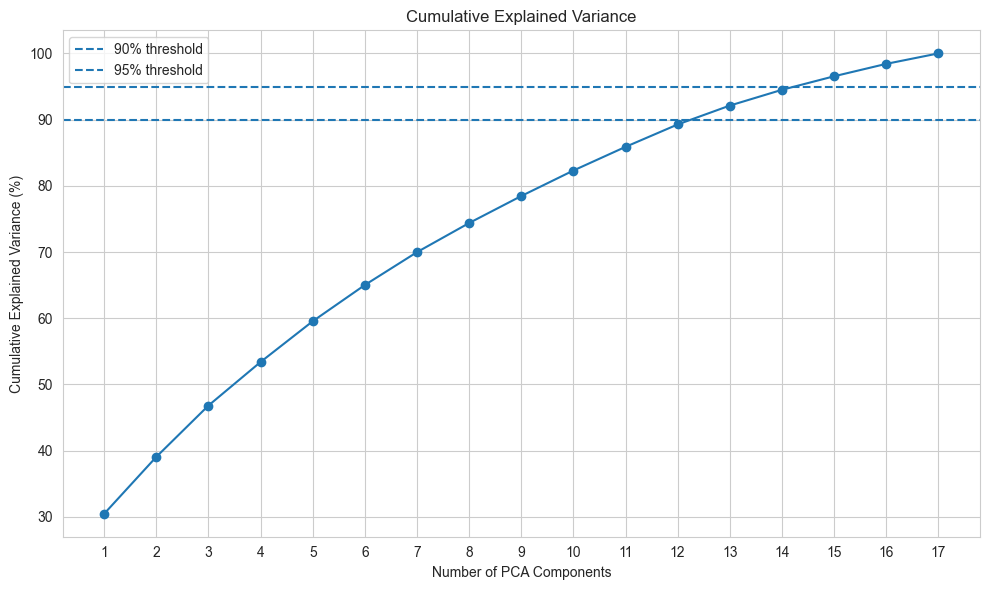

✅ 90% variance: 13 components
✅ 95% variance: 15 components
✅ 100% variance: 17 components
🖼️ Saved figure: data/only_Q_outputs/seperated/ses1_figures\b_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 13


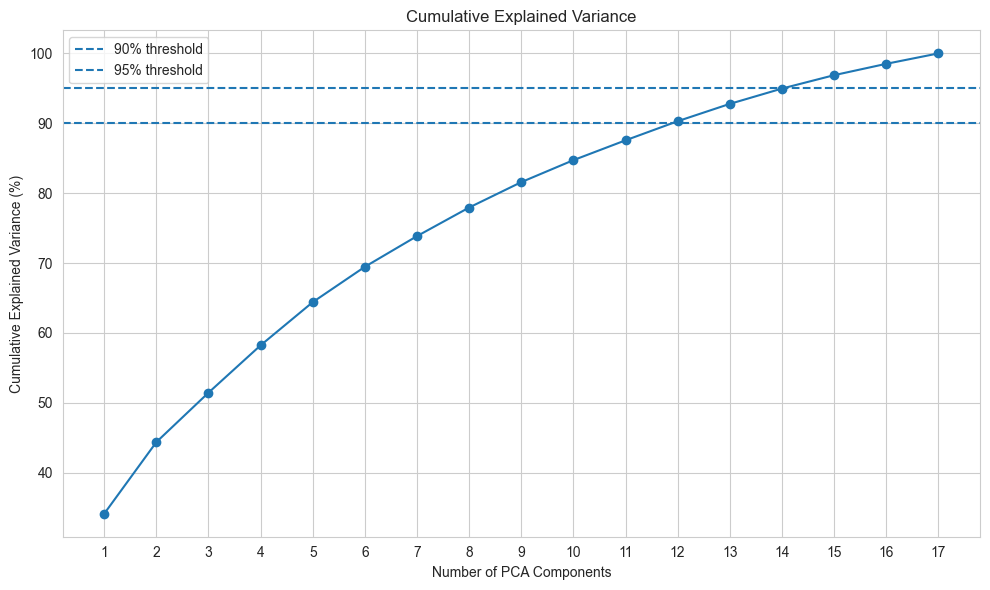

✅ 90% variance: 12 components
✅ 95% variance: 15 components
✅ 100% variance: 17 components
🖼️ Saved figure: data/only_Q_outputs/seperated/ses1_figures\t1_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 12


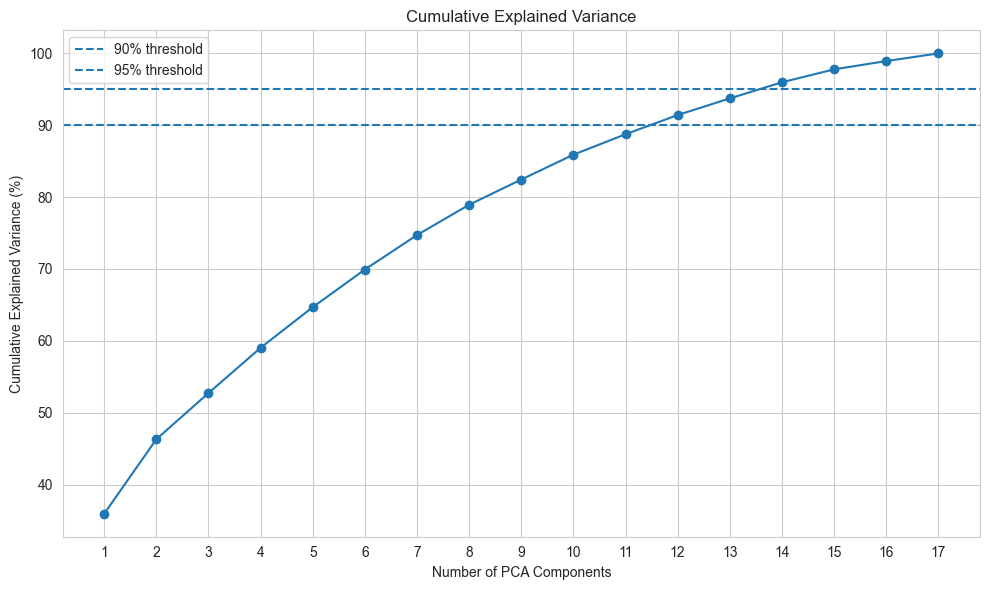

✅ 90% variance: 12 components
✅ 95% variance: 14 components
✅ 100% variance: 17 components
🖼️ Saved figure: data/only_Q_outputs/seperated/ses1_figures\t2_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 12


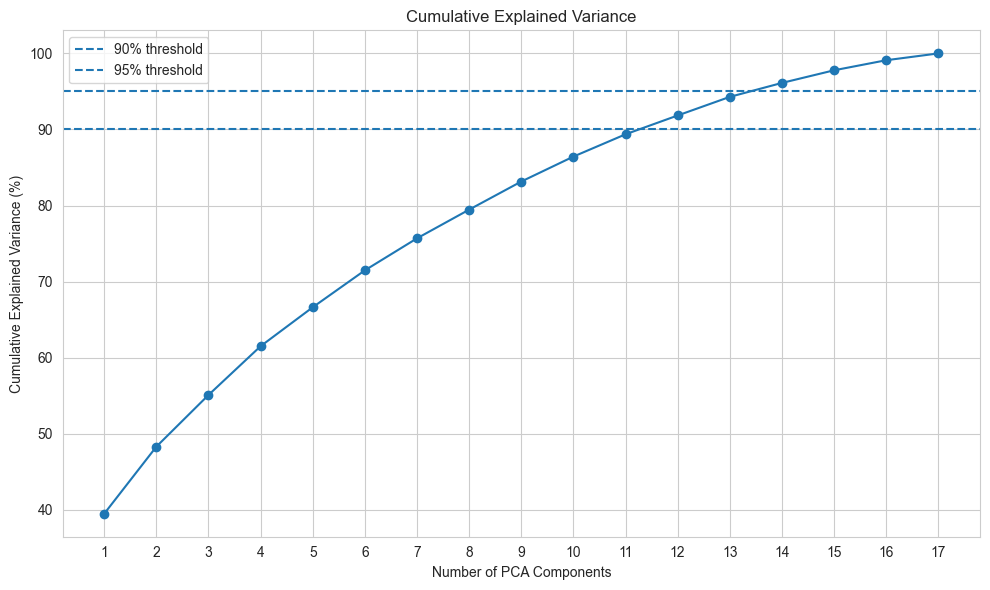

✅ 90% variance: 12 components
✅ 95% variance: 14 components
✅ 100% variance: 17 components
🖼️ Saved figure: data/only_Q_outputs/seperated/ses1_figures\t3_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 12


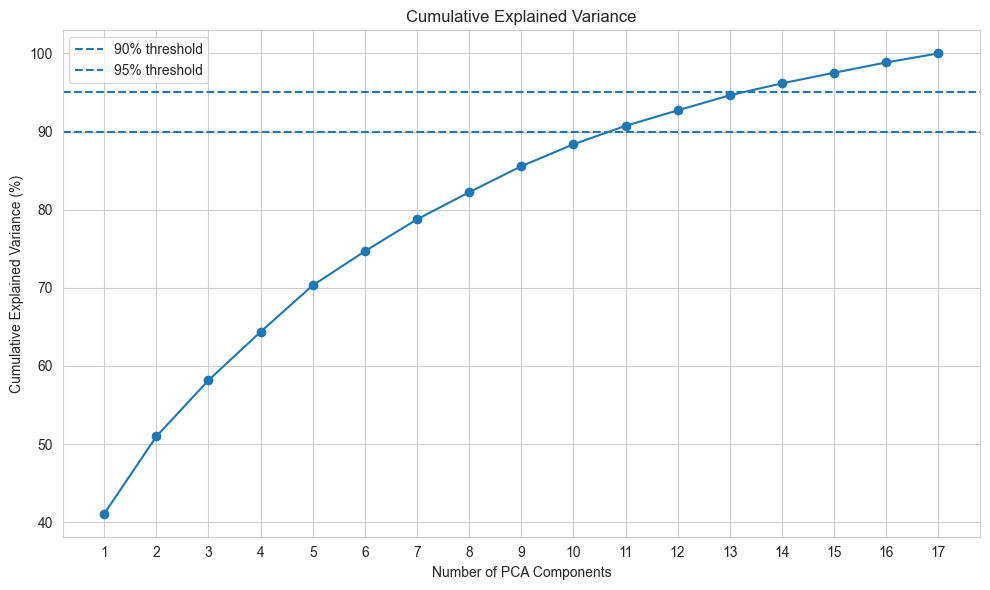

✅ 90% variance: 11 components
✅ 95% variance: 14 components
✅ 100% variance: 17 components
🖼️ Saved figure: data/only_Q_outputs/seperated/ses1_figures\after_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 11


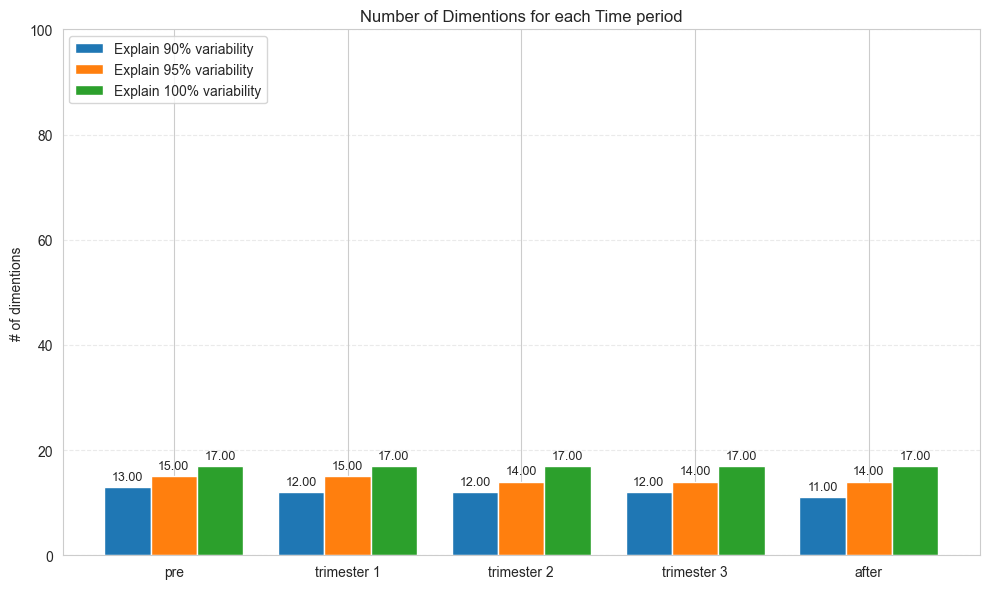

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Number of Dimentions for each Time period'}, ylabel='# of dimentions'>)

In [9]:
n_dims_b_90, n_dims_b_95, n_dims_b_100 = find_optimal_pca_dimensions(q_before,save_dir="data/only_Q_outputs/seperated/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_b_90}")

n_dims_t1_90, n_dims_t1_95, n_dims_t1_100 = find_optimal_pca_dimensions(q_t1,save_dir="data/only_Q_outputs/seperated/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_t1_90}")

n_dims_t2_90, n_dims_t2_95, n_dims_t2_100 = find_optimal_pca_dimensions(q_t2,save_dir="data/only_Q_outputs/seperated/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_t2_90}")

n_dims_t3_90, n_dims_t3_95, n_dims_t3_100 = find_optimal_pca_dimensions(q_t3,save_dir="data/only_Q_outputs/seperated/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_t3_90}")

n_dims_after_90, n_dims_after_95, n_dims_after_100 = find_optimal_pca_dimensions(q_after,save_dir="data/only_Q_outputs/seperated/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_after_90}")

groups = ["pre", "trimester 1", "trimester 2", "trimester 3", "after"]
s1 = [n_dims_b_90, n_dims_t1_90, n_dims_t2_90, n_dims_t3_90, n_dims_after_90]  # values for column 1 in each
s2 = [n_dims_b_95, n_dims_t1_95, n_dims_t2_95, n_dims_t3_95, n_dims_after_95]  # values for column 2
s3 = [n_dims_b_100, n_dims_t1_100, n_dims_t2_100, n_dims_t3_100, n_dims_after_100]  # values for column 2

plot_grouped_bars(groups, s1, s2, s3,
                  s1_label="Explain 90% variability",
                  s2_label="Explain 95% variability",
                  s3_label="Explain 100% variability",
                  title="Number of Dimentions for each Time period",
                  ylabel="# of dimentions")



## searc for optimal clusters number


In [10]:
df_b = pd.read_csv(q_before)
df_t1 = pd.read_csv(q_t1)
df_t2 = pd.read_csv(q_t2)
df_t3 = pd.read_csv(q_t3)
df_after =pd.read_csv(q_after)

[[-0.69359601  2.59942963 -0.91233104 ... -0.39493797  0.86742669
  -0.46442606]
 [ 0.70195258  0.83477618  0.34683659 ... -0.39493797 -0.7787126
  -0.46442606]
 [ 0.70195258  0.83477618  0.34683659 ... -0.39493797  0.86742669
   1.47455273]
 ...
 [-0.69359601 -0.92987727  0.34683659 ... -0.39493797 -0.7787126
   1.47455273]
 [-0.69359601 -0.92987727 -0.91233104 ... -0.39493797  0.86742669
  -0.46442606]
 [ 0.70195258  0.83477618 -0.91233104 ... -0.39493797  0.86742669
   1.47455273]]


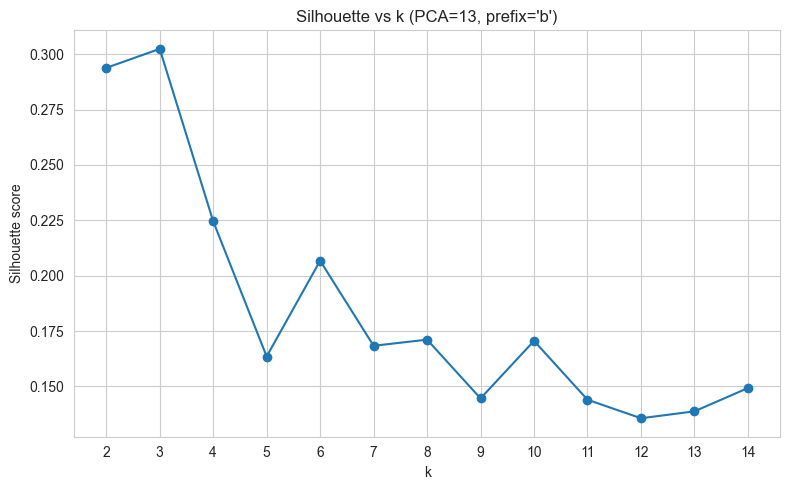


✅ מספר הקלאסטרים שנבחר לפי סילואט: 3
     subject_id  cluster  silhouette_sample
0             0        1          -0.145677
1             1        2           0.197878
2             2        1          -0.030500
3             3        2           0.409513
4             4        2           0.436929
..          ...      ...                ...
162         162        1          -0.033236
163         163        2           0.319558
164         164        2           0.227484
165         165        1          -0.134853
166         166        1          -0.112844

[167 rows x 3 columns]
[[-0.852484    0.5433481   0.64915263 ... -0.32758621  0.3855884
  -0.68002842]
 [ 0.32362819 -0.80596635 -1.34515133 ... -0.32758621  0.3855884
  -0.68002842]
 [-0.852484    0.5433481   1.64630461 ... -0.32758621  0.3855884
  -0.68002842]
 ...
 [-0.852484   -0.80596635 -1.34515133 ... -0.32758621 -0.89113764
   0.76746065]
 [ 0.32362819 -0.80596635  0.64915263 ... -0.32758621  0.3855884
   0.76746065]
 [ 0

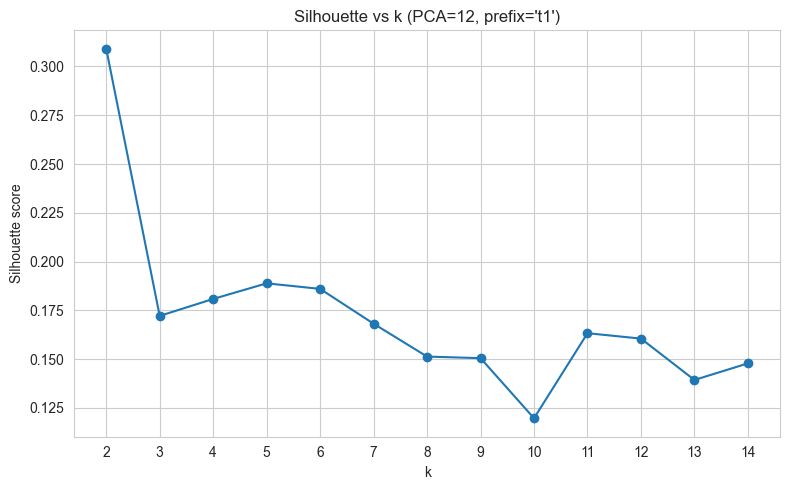


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        0           0.313592
1             1        0           0.524928
2             2        0           0.355294
3             3        0           0.544716
4             4        0           0.509776
..          ...      ...                ...
144         144        0           0.285675
145         145        0           0.298627
146         146        0           0.513888
147         147        0           0.315502
148         148        0           0.501326

[149 rows x 3 columns]
[[ 0.71247696  0.55932921 -1.27451208 ... -0.32494065 -0.82751593
  -0.74357315]
 [-0.73312846 -0.83899381  0.87526733 ... -0.32494065  0.55167728
  -0.74357315]
 [-0.73312846 -0.83899381 -0.19962237 ... -0.32494065 -0.82751593
   0.70226353]
 ...
 [ 0.71247696  0.55932921 -0.19962237 ... -0.32494065  0.55167728
  -0.74357315]
 [-0.73312846 -0.83899381 -0.19962237 ... -0.32494065 -0.82751593
  -0.74357315]


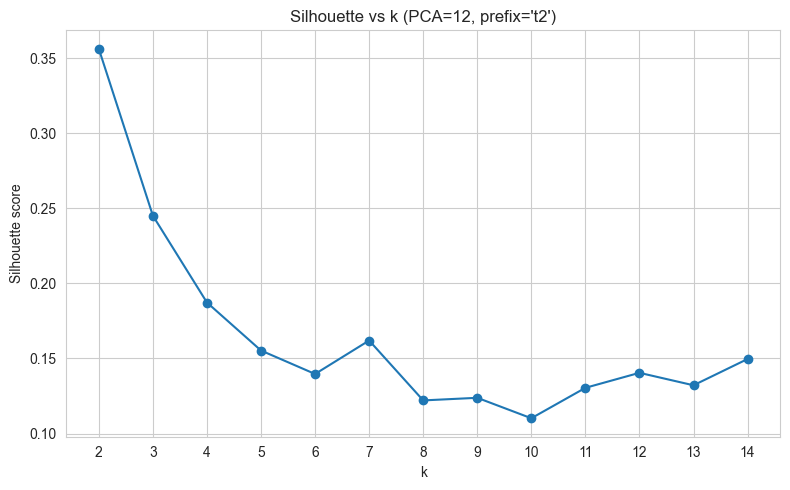


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        0           0.336557
1             1        0           0.421544
2             2        0           0.513677
3             3        0           0.582901
4             4        0           0.375381
..          ...      ...                ...
135         135        1           0.112050
136         136        0           0.578409
137         137        0           0.197929
138         138        0           0.554738
139         139        0           0.546720

[140 rows x 3 columns]
[[ 0.93277522  0.7370514   0.58444903 ... -0.30235395 -0.80010513
  -0.63472647]
 [ 0.93277522 -0.80837896 -0.45635061 ... -0.30235395  0.51652357
   0.8387457 ]
 [-0.68403516  0.7370514   0.58444903 ... -0.30235395  0.51652357
   0.8387457 ]
 ...
 [-0.68403516 -0.80837896 -0.45635061 ... -0.30235395  0.51652357
  -0.63472647]
 [-0.68403516  0.7370514  -0.45635061 ... -0.30235395 -0.80010513
   0.8387457 ]


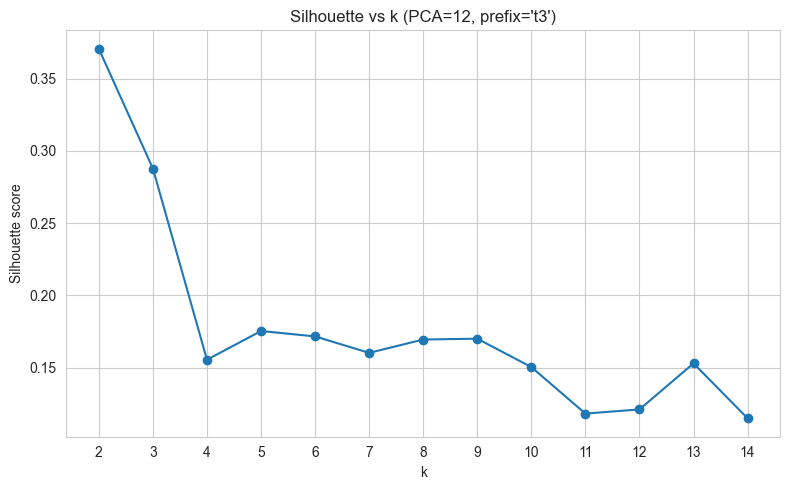


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        0           0.383604
1             1        0           0.415284
2             2        1          -0.277769
3             3        0           0.608995
4             4        0           0.482199
..          ...      ...                ...
125         125        0           0.334139
126         126        0           0.570895
127         127        0           0.356701
128         128        0           0.501981
129         129        0           0.571351

[130 rows x 3 columns]
[[ 0.9943048  -0.94826705  0.3479289  ... -0.25970495 -0.84134975
  -0.6887949 ]
 [ 0.9943048   0.57111538  1.43810612 ... -0.25970495  1.60463611
   0.69863483]
 [-0.58094213 -0.94826705  1.43810612 ... -0.25970495 -0.84134975
  -0.6887949 ]
 ...
 [-0.58094213 -0.94826705  0.3479289  ... -0.25970495  0.38164318
   2.08606457]
 [ 0.9943048   0.57111538 -0.74224832 ... -0.25970495 -0.84134975
   0.69863483]


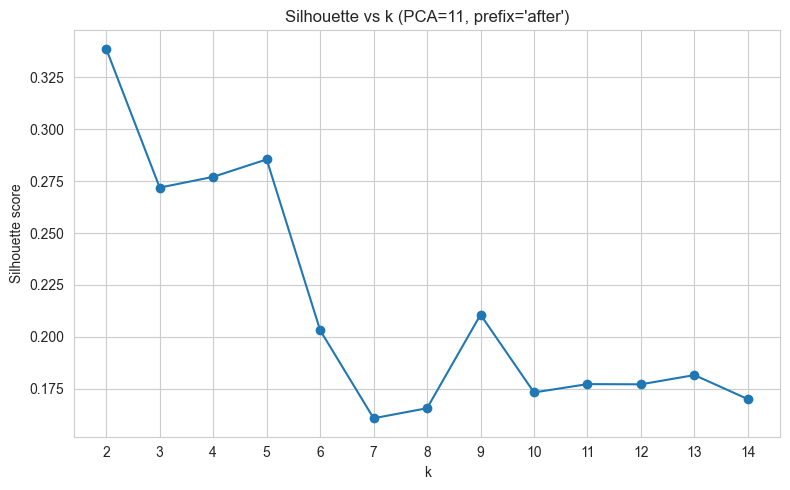


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        1           0.551735
1             1        0          -0.061039
2             2        1           0.322885
3             3        1           0.628898
4             4        0          -0.122576
..          ...      ...                ...
136         136        1           0.175636
137         137        0           0.223050
138         138        1           0.332392
139         139        0           0.006322
140         140        1           0.548351

[141 rows x 3 columns]


In [11]:
res_b = pca_kmeans_minimal_outputs(
    df_b,
    prefix="b",
    n_components=n_dims_b_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir="data/only_Q_outputs/seperated"
)


# You already found that e.g., 22 PCA components explain 95% of variance
res_t1 = pca_kmeans_minimal_outputs(
    df_t1,
    prefix="t1",
    n_components=n_dims_t1_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir="data/only_Q_outputs/seperated"
)


# Load your Excel file

# You already found that e.g., 22 PCA components explain 95% of variance
res_t2 = pca_kmeans_minimal_outputs(
    df_t2,
    prefix="t2",
    n_components=n_dims_t2_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir="data/only_Q_outputs/seperated")


# You already found that e.g., 22 PCA components explain 95% of variance
res_t3 = pca_kmeans_minimal_outputs(
    df_t3,
    prefix="t3",
    n_components=n_dims_t3_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir="data/only_Q_outputs/seperated")


# You already found that e.g., 22 PCA components explain 95% of variance
res_after = pca_kmeans_minimal_outputs(
    df_after,
    prefix="after",
    n_components=n_dims_after_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir= "data/only_Q_outputs/seperated")

In [12]:
sil_scores_b = res_b["sil_scores"]
print("k* =", res_b["best_k"])

sil_scores_t1 = res_t1["sil_scores"]
print("k* =", res_t1["best_k"])

sil_scores_t2 = res_t2["sil_scores"]
print("k* =", res_t2["best_k"])

sil_scores_t3 = res_t3["sil_scores"]
print("k* =", res_t3["best_k"])

sil_scores_after = res_after["sil_scores"]
print("k* =", res_after["best_k"])

ks = list(range(2, 15))  # same k_range you used in the runs

sil_b = res_b["sil_scores"].iloc[:, 0].values
sil_t1 = res_t1["sil_scores"].iloc[:, 0].values
sil_t2 = res_t2["sil_scores"].iloc[:, 0].values
sil_t3 = res_t3["sil_scores"].iloc[:, 0].values
sil_after = res_after["sil_scores"].iloc[:, 0].values

best_k_b_sil = res_b["best_k"]
best_k_t1_sil = res_t1["best_k"]
best_k_t2_sil = res_t2["best_k"]
best_k_t3_sil = res_t3["best_k"]
best_k_after_sil = res_after["best_k"]

k* = 3
k* = 2
k* = 2
k* = 2
k* = 2


## mark timeperiods on the pca data

## mark subjects trajectory on the pca data

Cluster assignments saved to data/only_Q_outputs/seperated/clusters_before.csv
All PCs (PC1–PC13) saved to data/only_Q_outputs/seperated/pc1/before_data.csv


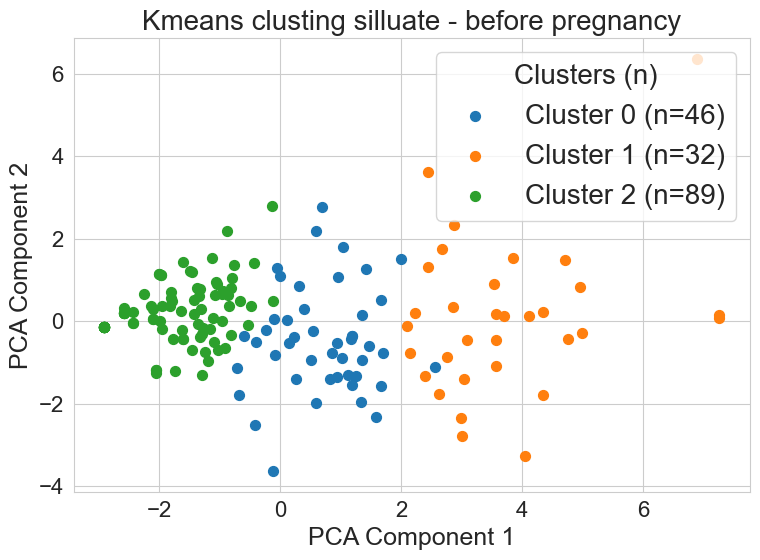

Cluster assignments saved to data/only_Q_outputs/seperated/clusters_t1.csv
All PCs (PC1–PC12) saved to data/only_Q_outputs/seperated/pc1/t1_data.csv


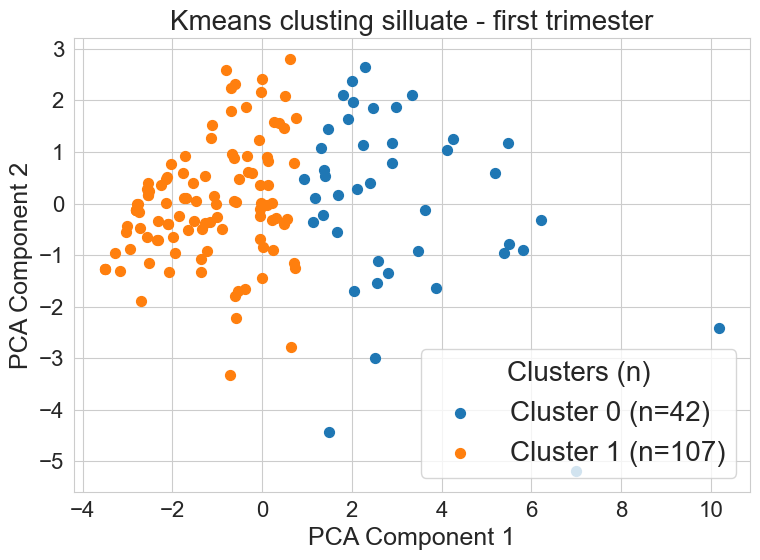

Cluster assignments saved to data/only_Q_outputs/seperated/clusters_t2.csv
All PCs (PC1–PC12) saved to data/only_Q_outputs/seperated/pc1/t2_data.csv


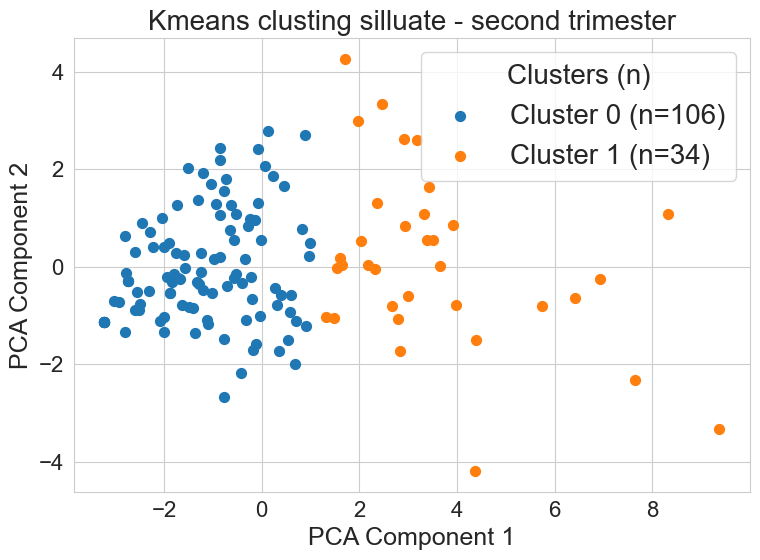

Cluster assignments saved to data/only_Q_outputs/seperated/clusters_t3.csv
All PCs (PC1–PC12) saved to data/only_Q_outputs/seperated/pc1/t3_data.csv


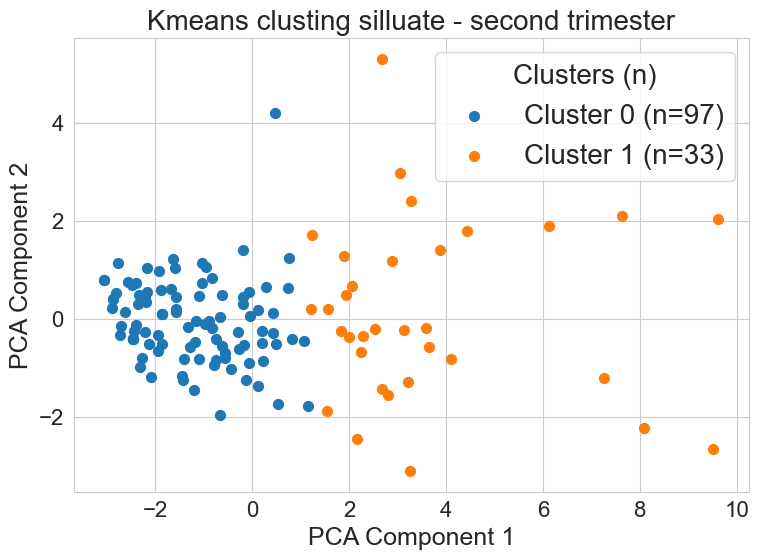

Cluster assignments saved to data/only_Q_outputs/seperated/clusters_after.csv
All PCs (PC1–PC11) saved to data/only_Q_outputs/seperated/pc1/after_data.csv


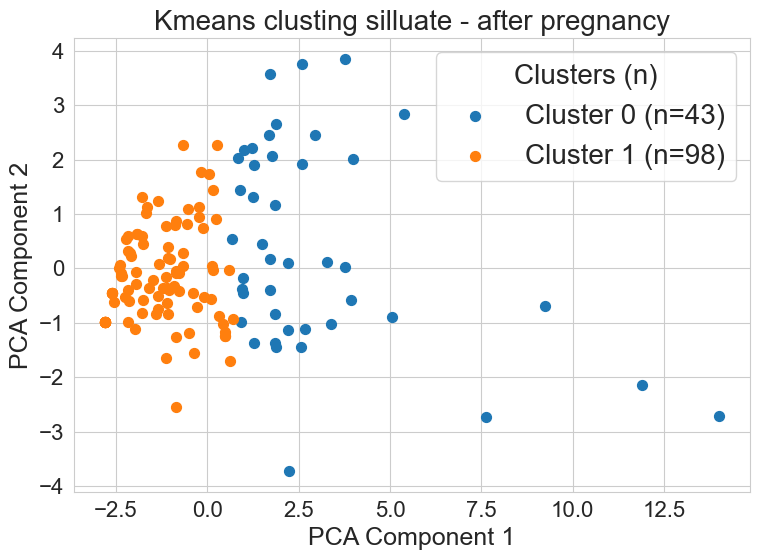

C:\Users\nogag\PycharmProjects\technion\vizualizations_functions.py:525: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


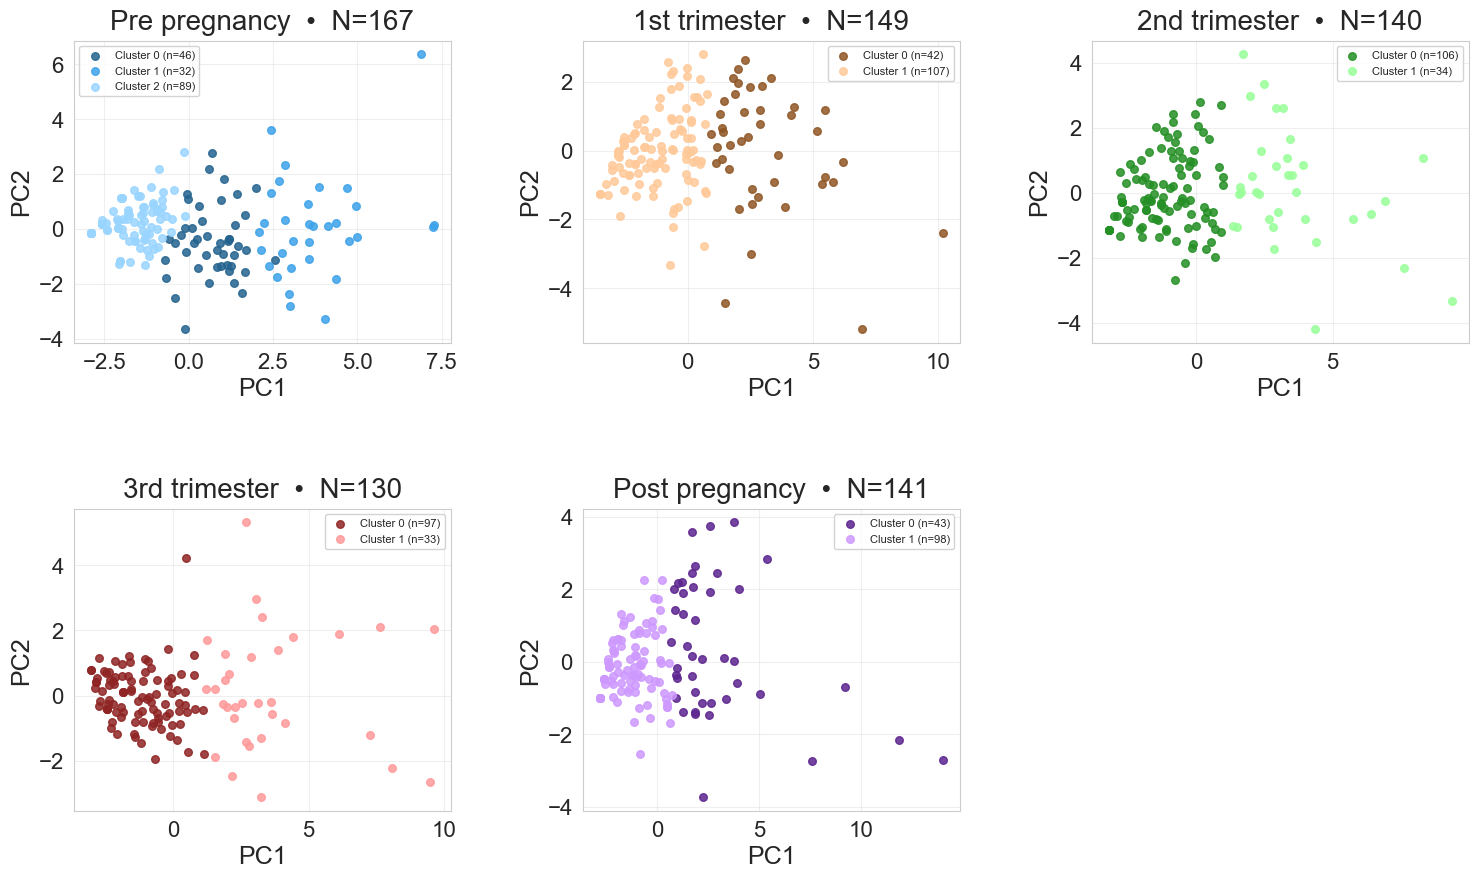

In [37]:
import os
labels_b_sil, data_pca_b_sil, model_b_sil, pca_b_sil = run_kmeans_clustering(
    df=df_b,
    prefix="b",  # your prefix
    n_components=n_dims_b_90,
    k=best_k_b_sil,  # from your gap statistic
    plot=True,
    title="Kmeans clusting silluate - before pregnancy",
    csv_path="data/only_Q_outputs/seperated/clusters_before.csv",
    pc1_csv_path = 'data/only_Q_outputs/seperated/pc1/before_data.csv')

labels_t1_sil, data_pca_t1_sil, model_t1_sil, pca_t1 = run_kmeans_clustering(
    df=df_t1,
    prefix="t1",  # your prefix
    n_components=n_dims_t1_90,
    k=best_k_t1_sil,  # from your gap statistic
    plot=True,
    title="Kmeans clusting silluate - first trimester",
    csv_path="data/only_Q_outputs/seperated/clusters_t1.csv",
    pc1_csv_path = 'data/only_Q_outputs/seperated/pc1/t1_data.csv'
)

labels_t2_sil, data_pca_t2_sil, model_t2_sil, pca_t2 = run_kmeans_clustering(
    df=df_t2,
    prefix="t2",  # your prefix
    n_components=n_dims_t2_90,
    k=best_k_t2_sil,  # from your gap statistic
    plot=True,
    title="Kmeans clusting silluate - second trimester",
    csv_path="data/only_Q_outputs/seperated/clusters_t2.csv",
    pc1_csv_path = 'data/only_Q_outputs/seperated/pc1/t2_data.csv'
)

labels_t3_sil, data_pca_t3_sil, model_t3_sil, pca_t3 = run_kmeans_clustering(
    df=df_t3,
    prefix="t3",  # your prefix
    n_components=n_dims_t3_90,
    k=best_k_t3_sil,  # from your gap statistic
    plot=True,
    title="Kmeans clusting silluate - second trimester",
    csv_path="data/only_Q_outputs/seperated/clusters_t3.csv",
    pc1_csv_path = 'data/only_Q_outputs/seperated/pc1/t3_data.csv'
)

labels_after_sil, data_pca_after_sil, model_after_sil, pca_after = run_kmeans_clustering(
    df=df_after,
    prefix="after",  # your prefix
    n_components=n_dims_after_90,
    k=best_k_after_sil,  # from your gap statistic
    plot=True,
    title="Kmeans clusting silluate - after pregnancy",
    csv_path="data/only_Q_outputs/seperated/clusters_after.csv",
    pc1_csv_path = 'data/only_Q_outputs/seperated/pc1/after_data.csv'
)
plot_multi_dataset_scatters_colored(
    datasets=[data_pca_b_sil, data_pca_t1_sil, data_pca_t2_sil, data_pca_t3_sil, data_pca_after_sil],
    titles=["Pre pregnancy", "1st trimester", "2nd trimester", "3rd trimester", "Post pregnancy"],
    labels_list=[labels_b_sil, labels_t1_sil, labels_t2_sil, labels_t3_sil, labels_after_sil],
    x_idx=0, y_idx=1,
    base_colors=["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"],
    show_counts=True,  # <-- on
    show_percent=False  # <-- optional %
)

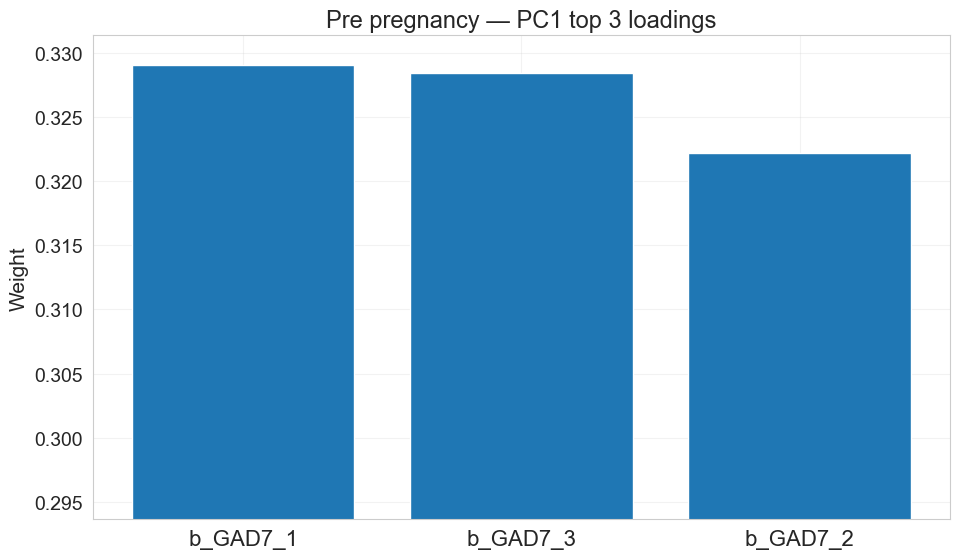

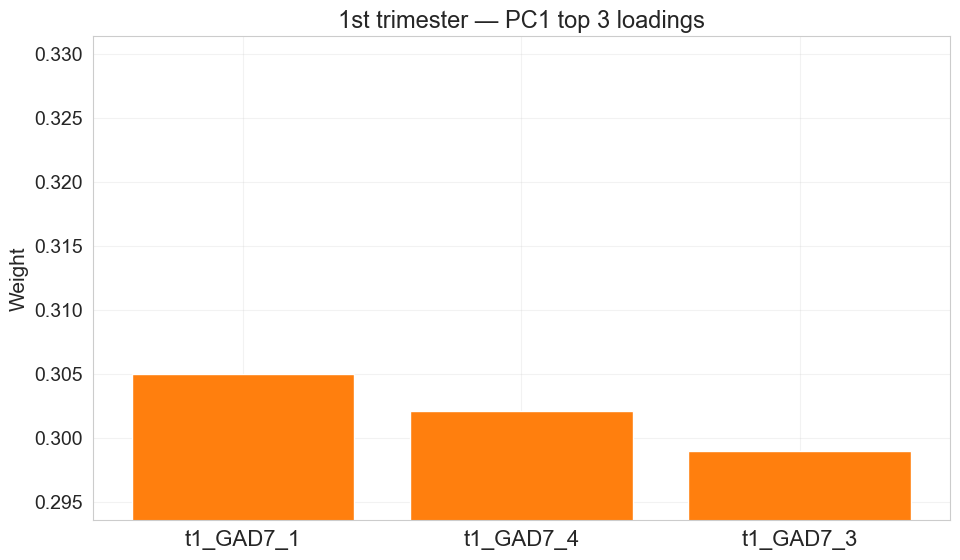

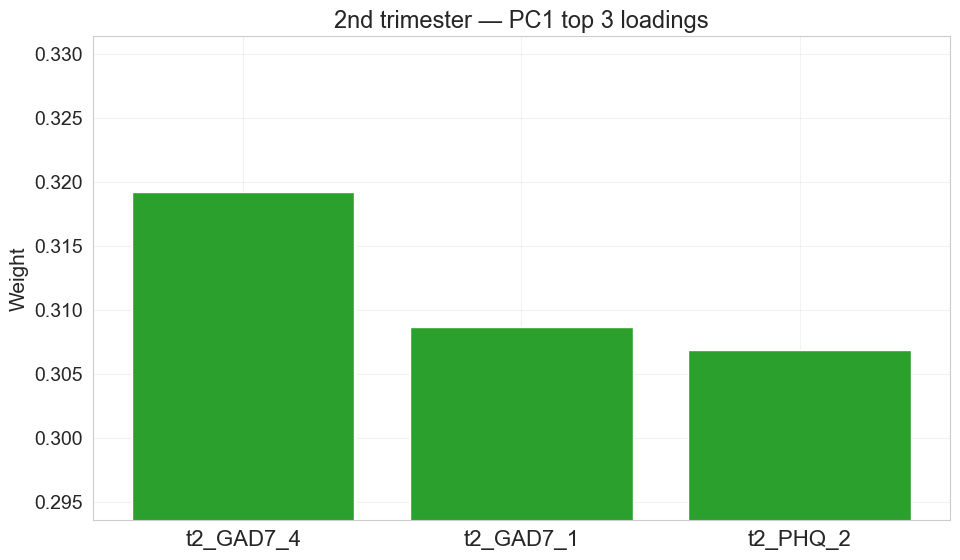

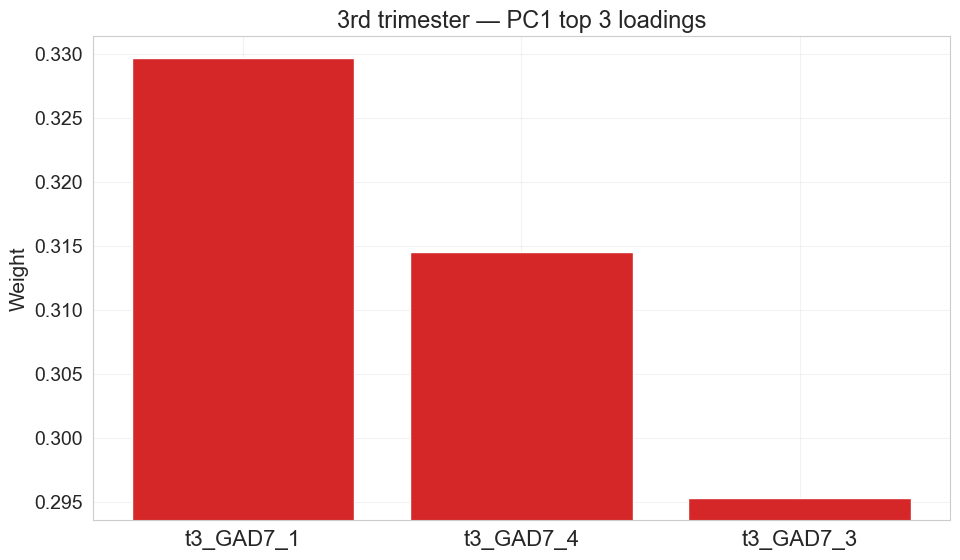

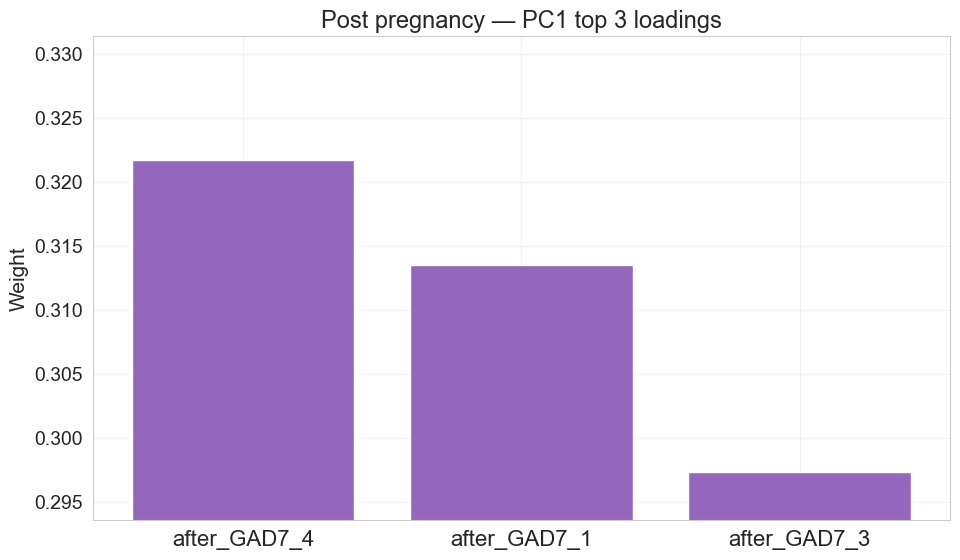

          dataset  pc  rank_within_dataset       feature   loading  \
0   1st trimester   1                    1     t1_GAD7_1  0.305001   
1   1st trimester   1                    2     t1_GAD7_4  0.302125   
2   1st trimester   1                    3     t1_GAD7_3  0.298995   
3   2nd trimester   1                    1     t2_GAD7_4  0.319242   
4   2nd trimester   1                    2     t2_GAD7_1  0.308708   
5   2nd trimester   1                    3      t2_PHQ_2  0.306900   
6   3rd trimester   1                    1     t3_GAD7_1  0.329691   
7   3rd trimester   1                    2     t3_GAD7_4  0.314548   
8   3rd trimester   1                    3     t3_GAD7_3  0.295337   
9  Post pregnancy   1                    1  after_GAD7_4  0.321737   

   abs_loading  
0     0.305001  
1     0.302125  
2     0.298995  
3     0.319242  
4     0.308708  
5     0.306900  
6     0.329691  
7     0.314548  
8     0.295337  
9     0.321737  


In [38]:
# PC1 (pc_index=0), top 15:
df_pc1 = plot_pca_weights_separate_and_table(
    pcas=[pca_b_sil, pca_t1, pca_t2, pca_t3, pca_after],
    dfs=[df_b, df_t1, df_t2, df_t3, df_after],
    prefixes=["b", "t1", "t2", "t3", "after"],
    titles=["Pre pregnancy", "1st trimester", "2nd trimester", "3rd trimester", "Post pregnancy"],
    pc_index=0,
    top_n=3,
    figsize=(10, 6),
    fontsize=15,
    save_csv_path="data/only_Q_outputs/seperated/top_loadings_PC1.csv"  # או "top_loadings_PC1.csv"
)

# הצצה לטבלה:
print(df_pc1.head(10))

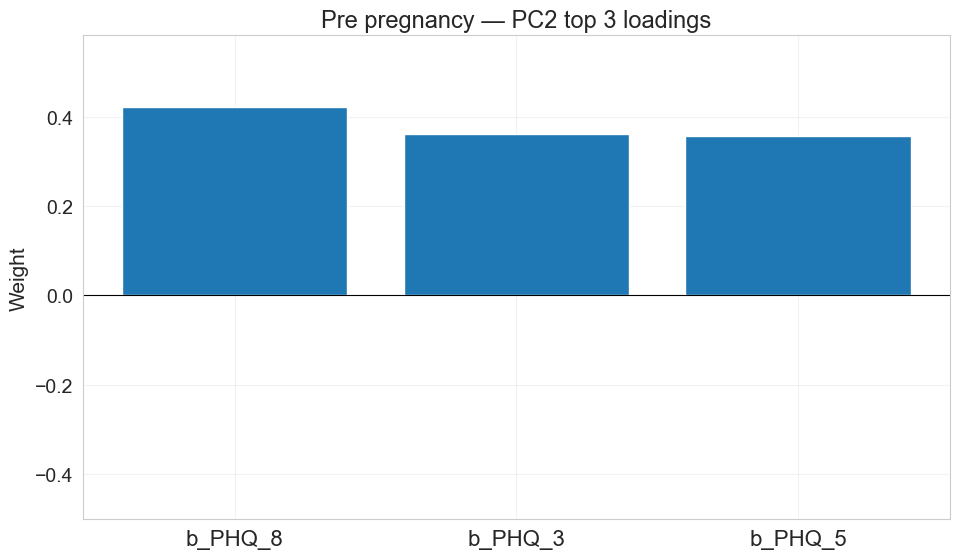

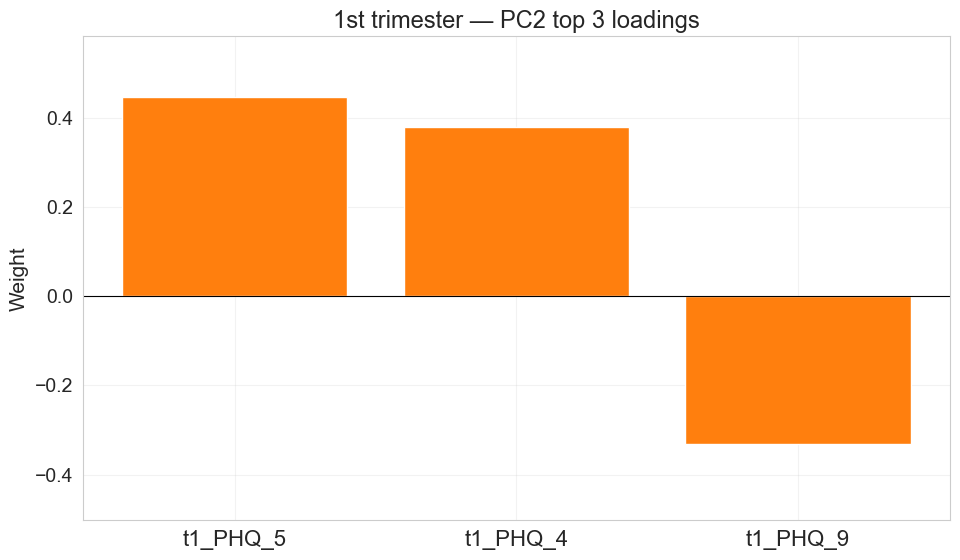

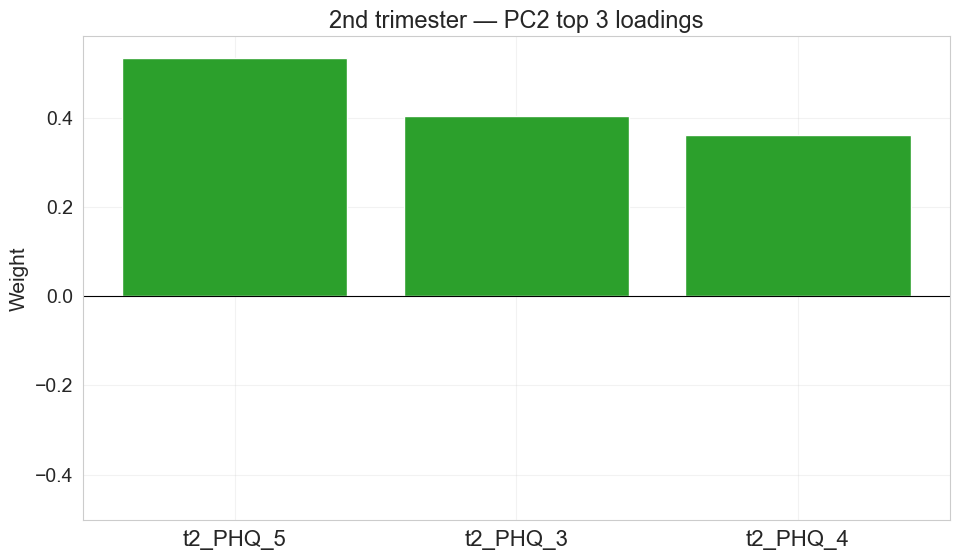

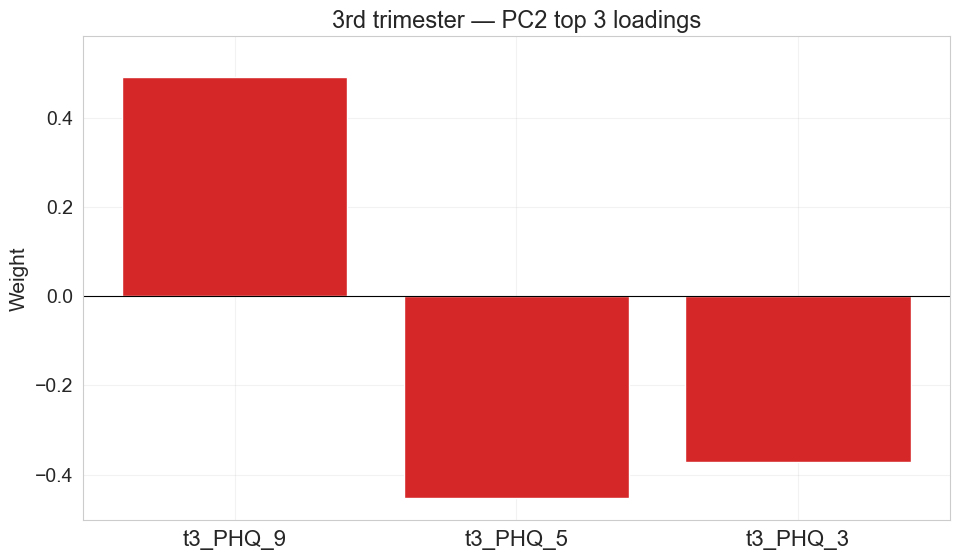

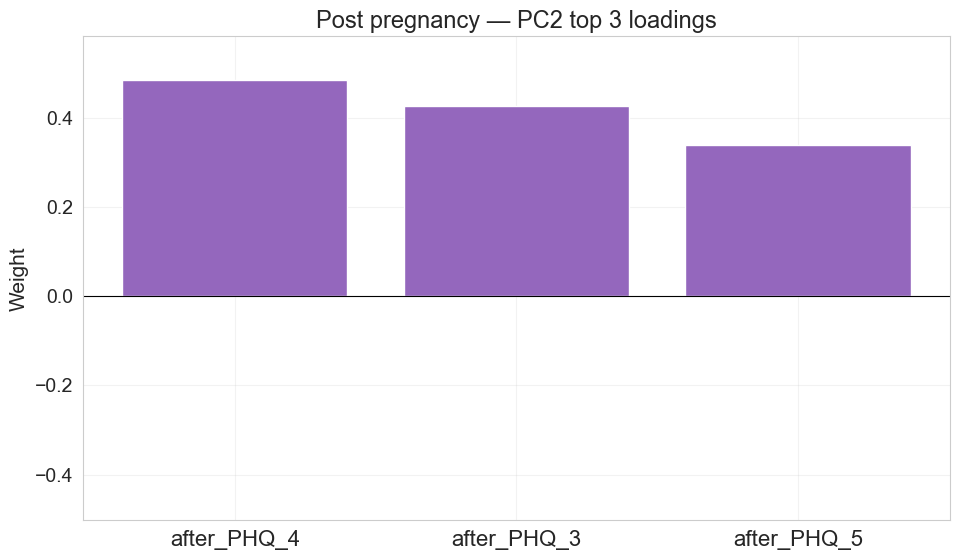

          dataset  pc  rank_within_dataset      feature   loading  abs_loading
0   1st trimester   2                    1     t1_PHQ_5  0.445885     0.445885
1   1st trimester   2                    2     t1_PHQ_4  0.380667     0.380667
2   1st trimester   2                    3     t1_PHQ_9 -0.331185     0.331185
3   2nd trimester   2                    1     t2_PHQ_5  0.533660     0.533660
4   2nd trimester   2                    2     t2_PHQ_3  0.403296     0.403296
5   2nd trimester   2                    3     t2_PHQ_4  0.360616     0.360616
6   3rd trimester   2                    1     t3_PHQ_9  0.492414     0.492414
7   3rd trimester   2                    2     t3_PHQ_5 -0.452843     0.452843
8   3rd trimester   2                    3     t3_PHQ_3 -0.370931     0.370931
9  Post pregnancy   2                    1  after_PHQ_4  0.485973     0.485973


In [39]:
# PC1 (pc_index=0), top 15:
df_pc1 = plot_pca_weights_separate_and_table(
    pcas=[pca_b_sil, pca_t1, pca_t2, pca_t3, pca_after],
    dfs=[df_b, df_t1, df_t2, df_t3, df_after],
    prefixes=["b", "t1", "t2", "t3", "after"],
    titles=["Pre pregnancy", "1st trimester", "2nd trimester", "3rd trimester", "Post pregnancy"],
    pc_index=1,
    top_n=3,
    figsize=(10, 6),
    fontsize=15,
    save_csv_path="data/only_Q_outputs/seperated/top_loadings_PC1.csv"  # או "top_loadings_PC1.csv"
)

# הצצה לטבלה:
print(df_pc1.head(10))

## k means on the combined pca  dataset


## k meand per timepoint on the pca combined dataset

## plot the clustering of the combined dataset


## plotting the losings for pc1 and pc2

## merge the lcusters from the diffrent time points into one csv

In [40]:
# Map each file to the column name you want in the merged table
files = {
    "data/only_Q_outputs/seperated/clusters_before.csv": "before",
    "data/only_Q_outputs/seperated/clusters_t1.csv": "t1",
    "data/only_Q_outputs/seperated/clusters_t2.csv": "t2",
    "data/only_Q_outputs/seperated/clusters_t3.csv": "t3",
    "data/only_Q_outputs/seperated/clusters_after.csv": "after",

}


# Load and prepare all dataframes
dfs = [load_one(path, col) for path, col in files.items()]

# Outer-join on Subject_Code
merged = reduce(lambda left, right: pd.merge(left, right, on="Subject_Code", how="outer"), dfs)

# Replace NaN with None (optional)
merged = merged.where(pd.notna(merged), None)

# Save
merged.to_csv('data/only_Q_outputs/seperated/clusters_merged_by_subject_from_combined.csv', index=False)
print("Saved: clusters_merged_by_subject.csv")
print(merged.head())

Saved: clusters_merged_by_subject.csv
  Subject_Code  before   t1   t2   t3  after
0        CT002     2.0  NaN  NaN  NaN    NaN
1        CT003     0.0  1.0  0.0  0.0    1.0
2        CT004     2.0  1.0  0.0  0.0    0.0
3        CT005     1.0  0.0  0.0  1.0    1.0
4        CT007     1.0  0.0  1.0  1.0    0.0


## aligning the clusters


In [41]:
invert_binary_columns(
    input_path="data/only_Q_outputs/seperated/clusters_merged_by_subject_from_combined.csv",
    output_path='data/only_Q_outputs/seperated/timepoints_file_inverted_2.csv',
    column_names=["before","t1","after"]  # any set of binary columns
)




✅ File saved to data/only_Q_outputs/seperated/timepoints_file_inverted_2.csv


## pca again od specfied time ponts

In [43]:
import pandas as pd

# --- CONFIGURATION ---
input_file = "data/q_data/Study_Questionnaire_Responses_October.xlsx"

# Columns you want in the new file
columns_to_keep = ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction']
# <-- Replace ColumnA, ColumnB, ColumnC with the real column names you want.


# --- LOAD EXCEL FILE ---
df = pd.read_excel(input_file)
print(df.columns.to_list())
# --- CHECK IF COLUMNS EXIST ---
missing = [col for col in columns_to_keep if col not in df.columns]
if missing:
    print("❌ These columns do NOT exist in the file:", missing)
else:
    # --- SELECT COLUMNS ---
    new_df = df[columns_to_keep]

    # --- SAVE TO CSV ---
    new_df.to_csv("data/only_Q_outputs/seperated/regression_parameters_bits_mpas.csv", index=False)
    print("✅ File created: regression_parameters.csv")


['study_id', 'Subject_Code', 'diamond_interview_date', 'b_diamond_anxiety_phobias_past', 'b_diamond_Anxiety_phobias_present', 'b_diamond_ocd_past', 'b_diamond_ocd_present', 'b_diamond_adhd_past', 'b_diamond_adhd_present', 'b_diamond_depression_past', 'b_diamond_depression_present', 'b_diamond_adjustment_past', 'b_diamond_adjustment_present', 'b_diamond_ptsd_past', 'b_diamond_ptsd_present', 'b_diamond_eating_disorder_past', 'b_diamond_eating_disorder_present', 'b_diamond_PMS_past', 'b_diamond_PMS_present', 'b_diamond_other_past', 'b_diamond_other_present', 'b_diamond_past', 'b_diamond_present', 'Dropped_Out_of_Study', 'Became_Pregnant', 'Gave_Birth', 'Dominant_hand', 'Completed_First_fMRI', 'Completed_Second_fMRI', 'Completed_Third_fMRI', 'b_questionnaire_completion', 'after_questionnaire_completion', 'first_fmri_scan_date', 'second_fmri_scan_date', 'third_fmri_scan_date', 'b_questionnaire_and_fmri_days_difference', 'pregnancy_start_date', 'b_questionnaire_and_pregnancy_days_difference'

## creating a file with clusters and parmeters to check

In [46]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

timepoints_path = r"data/only_Q_outputs/seperated/timepoints_file_inverted_2.csv"
regression_path = r"data/only_Q_outputs/seperated/regression_parameters_bits_mpas.csv"

time_df = pd.read_csv(timepoints_path)
reg_df = pd.read_csv(regression_path)

# -------------------------
# 2. Choose columns from regression_parameters
#    Make sure "Subject_Code" is included
# -------------------------

# regression_cols = [
#     "Subject_Code"
#    ,'b_DERS_total','b_DES_average','after_DES_total','after_DERS_total'
# ]
regression_cols =  ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction']
reg_sel = reg_df[regression_cols].copy()

# helper: list of regression columns WITHOUT Subject_Code
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Filter subjects that have value in column 'b' / 'after'
#    Here "have value" = not NaN. If in your file it's 0/1, you can change to != 0.
# -------------------------

# subjects with value in column 'b'
b_subjects = time_df[time_df["before"].notna()].copy()
# e.g. if it's 0/1 then:
# b_subjects = time_df[time_df["b"] != 0].copy()

# subjects with value in column 'after'
after_subjects = time_df[time_df["after"].notna()].copy()
# or if it's 0/1:
# after_subjects = time_df[time_df["after"] != 0].copy()

# -------------------------
# 4. Merge with regression parameters on Subject_Code
# -------------------------

b_merged_full = pd.merge(
    b_subjects,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

after_merged_full = pd.merge(
    after_subjects,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Keep ONLY:
#    Subject_Code + wanted timepoint column + regression parameters
# -------------------------

b_final = b_merged_full[["Subject_Code", "before"] + reg_param_cols].copy()
after_final = after_merged_full[["Subject_Code", "after"] + reg_param_cols].copy()

# -------------------------
# 6. Save the two final files
# -------------------------
b_final = b_final.rename(columns={"before": "cluster"})
after_final = after_final.rename(columns={"after": "cluster"})

b_output_path = r"data/only_Q_outputs/seperated/subjects_b_with_regression_clean.csv"
after_output_path = r"data/only_Q_outputs/seperated/subjects_after_with_regression_clean.csv"

b_final.to_csv(b_output_path, index=False)
after_final.to_csv(after_output_path, index=False)

print("Saved:")
print(" -", b_output_path)
print(" -", after_output_path)


Saved:
 - data/only_Q_outputs/seperated/subjects_b_with_regression_clean.csv
 - data/only_Q_outputs/seperated/subjects_after_with_regression_clean.csv


## taking the dsta from before pregnancy and trying to compare the scores of the mpas and bits after pregnancy

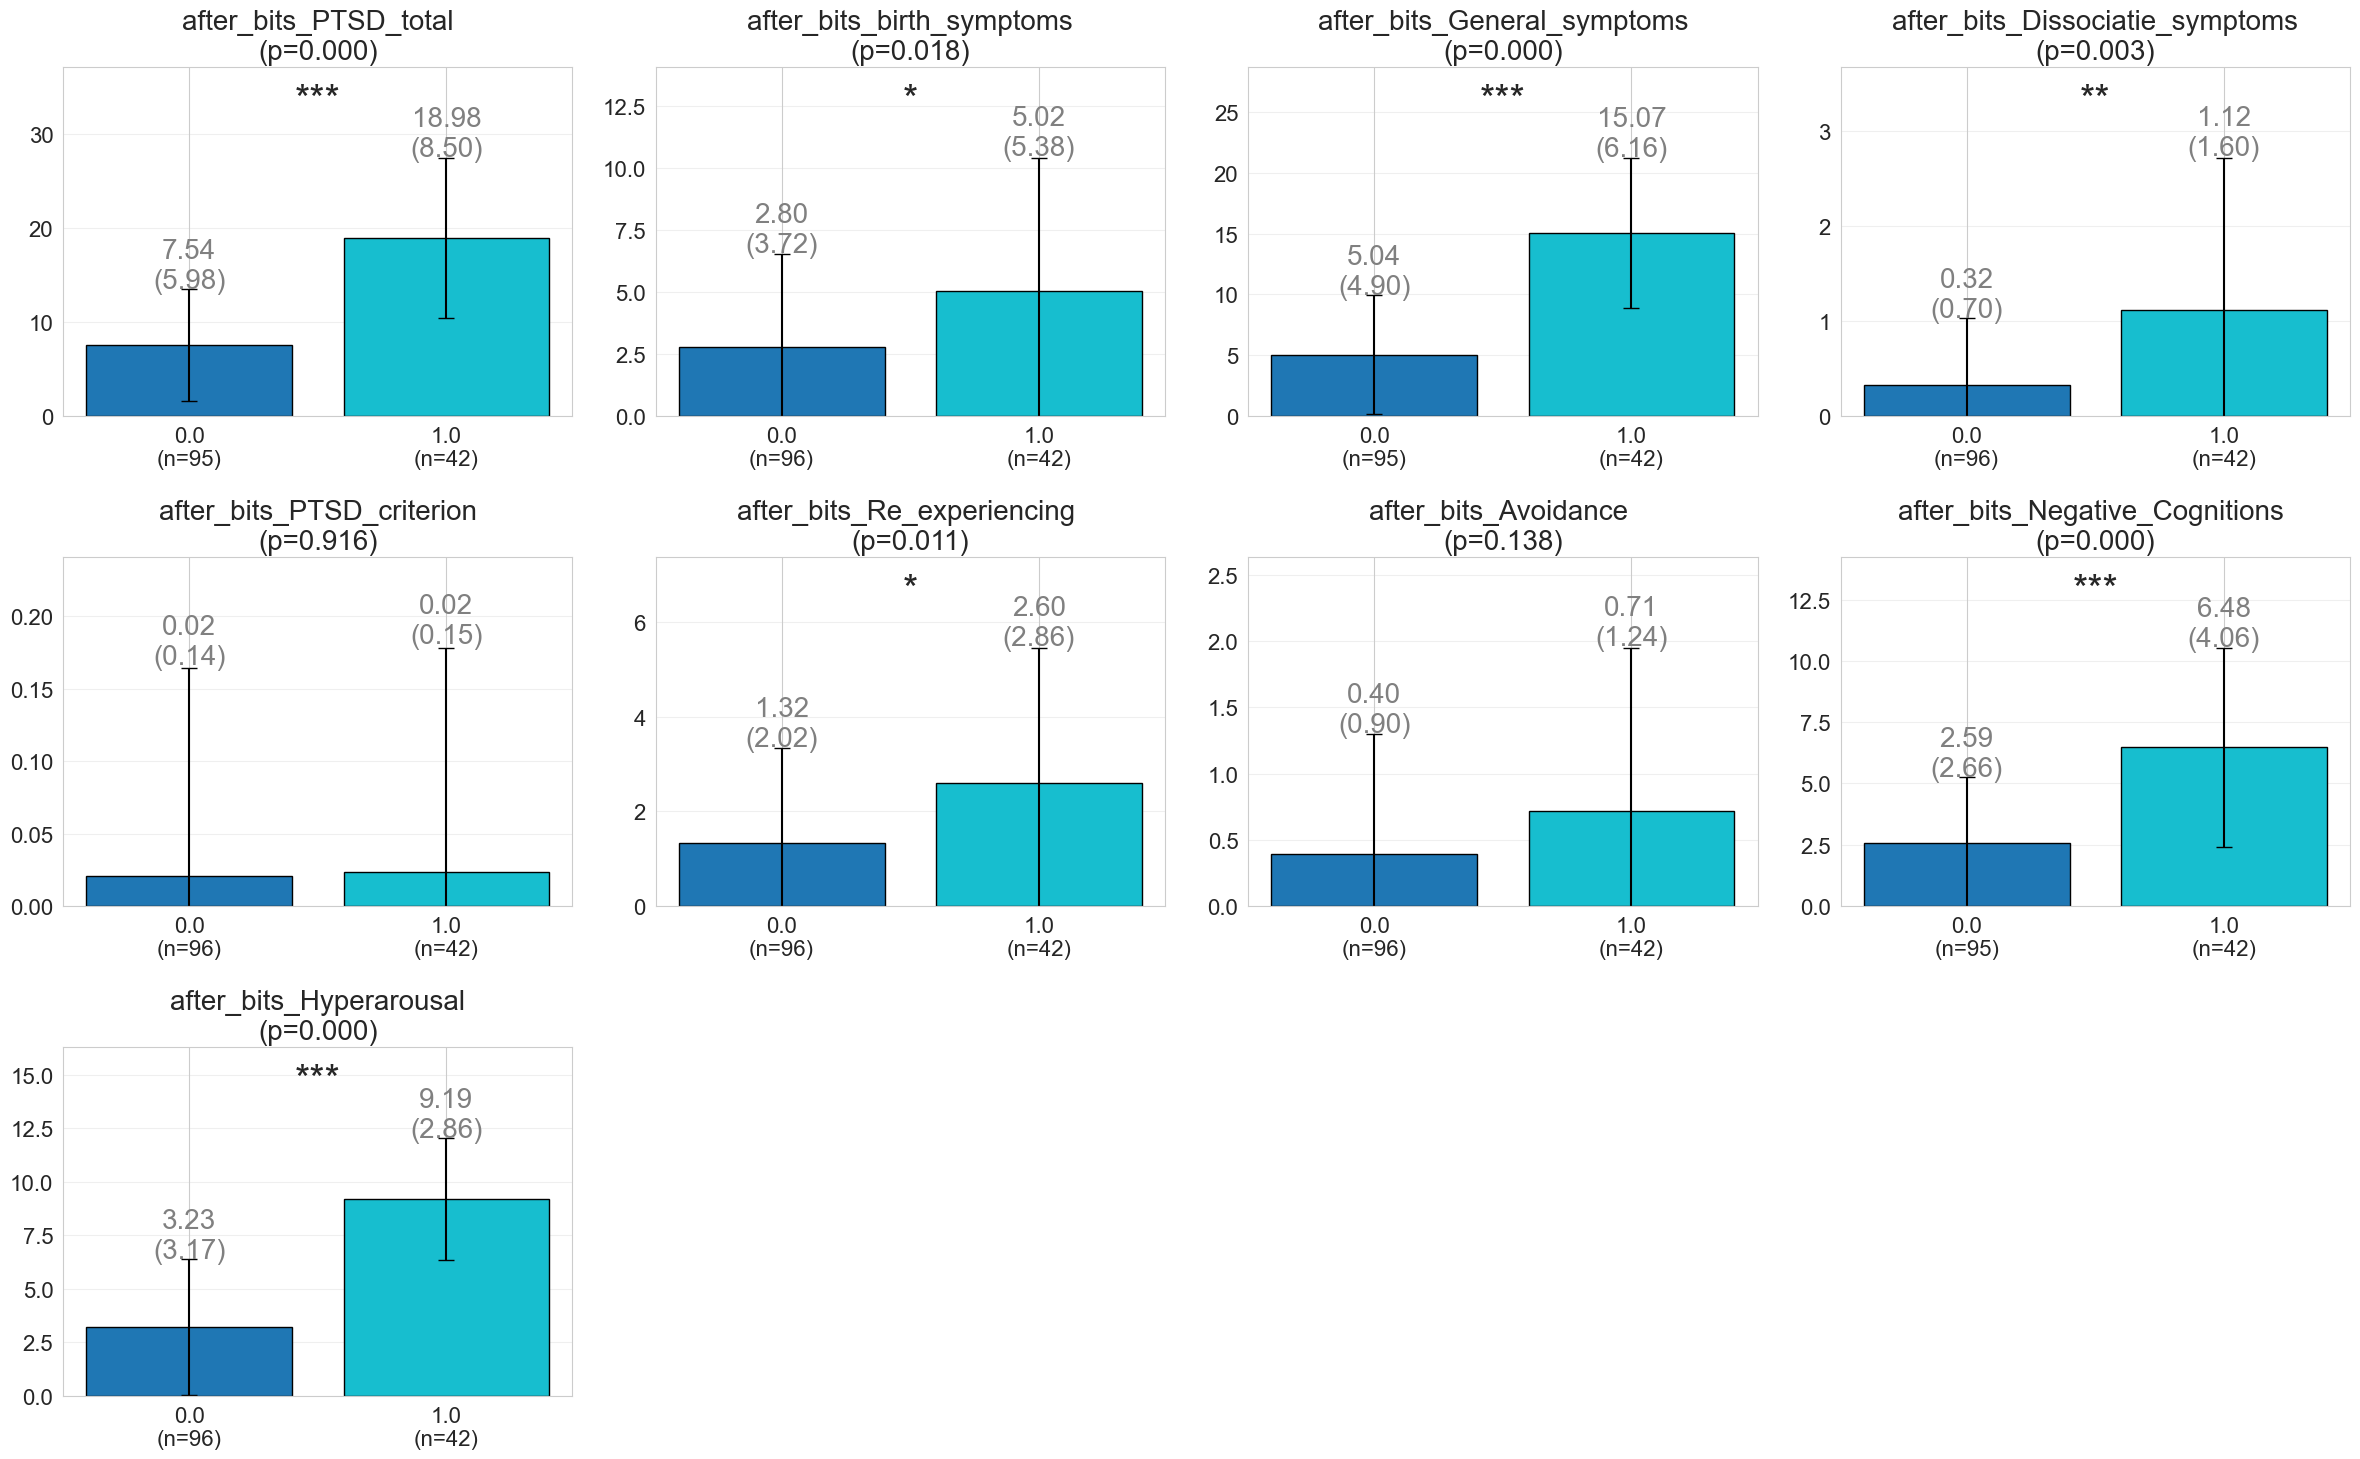

                          variable     mean0      std0  n0      mean1  \
0            after_bits_PTSD_total  7.536842  5.981906  95  18.976190   
1        after_bits_birth_symptoms  2.802083  3.715175  96   5.023810   
2      after_bits_General_symptoms  5.042105  4.896625  95  15.071429   
3  after_bits_Dissociatie_symptoms  0.322917  0.703297  96   1.119048   
4        after_bits_PTSD_criterion  0.020833  0.143576  96   0.023810   
5      after_bits_Re_experiencing   1.322917  2.023519  96   2.595238   
6            after_bits_Avoidance   0.395833  0.900049  96   0.714286   
7  after_bits_Negative_Cognitions   2.589474  2.663763  95   6.476190   
8          after_bits_Hyperarousal  3.229167  3.170519  96   9.190476   

       std1  n1         p_raw stars  
0  8.498172  42  7.476062e-11   ***  
1  5.380580  42  1.798379e-02     *  
2  6.162011  42  1.346639e-13   ***  
3  1.595762  42  3.194092e-03    **  
4  0.154303  42  9.155126e-01        
5  2.863219  42  1.146514e-02     *  
6  

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import math

# --------------------------------------------------
# GLOBAL FONT SETTINGS – makes EVERYTHING bigger
# --------------------------------------------------
plt.rcParams.update({
    'font.size': 20,         # default font size
    'axes.titlesize': 20,    # subplot titles
    'axes.labelsize': 18,    # axis labels
    'xtick.labelsize': 16,   # x-axis ticks
    'ytick.labelsize': 16,   # y-axis ticks
})

# --------------------------------------------------
# 1. Load your data
# --------------------------------------------------
df = pd.read_csv("data/only_Q_outputs/seperated/subjects_after_with_regression_clean.csv")

cluster_col = "cluster"

value_cols =  [ 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal']


# --------------------------------------------------
# 2. Clean variable names
# --------------------------------------------------
def clean_variable_name(var):
    """
    Example:
        after_DERS_total -> DERS
        after_DES_total  -> DES
    """
    parts = var.split("_")
    if len(parts) >= 3:
        return parts[1]  # the middle part
    return var


# --------------------------------------------------
# 3. Analysis & Plotting Function (NO FDR)
# --------------------------------------------------
def compare_clusters_no_fdr(df, cluster_col, value_cols):

    df = df.dropna(subset=[cluster_col]).copy()

    # Colors
    cluster_values = sorted(df[cluster_col].unique())
    base_colors = ["#1f77b4", "#17becf"]
    color_map = {cluster_values[i]: base_colors[i % 2] for i in range(len(cluster_values))}

    stats_list = []

    # -----------------------------
    # 1. COLLECT ALL STATS FIRST
    # -----------------------------
    for col in value_cols:
        g0 = df[df[cluster_col] == cluster_values[0]][col].dropna()
        g1 = df[df[cluster_col] == cluster_values[1]][col].dropna()

        _, p = ttest_ind(g0, g1, equal_var=False, nan_policy="omit")

        stats_list.append({
            "variable": col,
            "mean0": g0.mean(),
            "std0": g0.std(),
            "n0": g0.size,
            "mean1": g1.mean(),
            "std1": g1.std(),
            "n1": g1.size,
            "p_raw": p,
            "stars": "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        })

    # -----------------------------
    # 2. CREATE ONE BIG FIGURE
    # -----------------------------
    n_cols = 4
    n_rows = math.ceil(len(value_cols) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten()

    for ax, s in zip(axes, stats_list):

        means = [s["mean0"], s["mean1"]]
        stds  = [s["std0"], s["std1"]]
        ns    = [s["n0"], s["n1"]]

        x = np.arange(2)
        bar_colors = [color_map[cluster_values[0]], color_map[cluster_values[1]]]

        ax.bar(x, means, yerr=stds, capsize=6, color=bar_colors, edgecolor="black")

        ax.set_xticks(x)
        ax.set_xticklabels([
            f"{cluster_values[0]}\n(n={ns[0]})",
            f"{cluster_values[1]}\n(n={ns[1]})"
        ])

        y_top = max(m + sd for m, sd in zip(means, stds))
        ax.set_ylim(0, y_top * 1.35)

        ax.text(0.5, y_top * 1.18, s["stars"], ha="center", fontsize=28)

        for xi, m, sd in zip(x, means, stds):
            ax.text(xi, m + sd * 1.02, f"{m:.2f}\n({sd:.2f})",
                    ha="center", color="gray")

        ax.set_title(f"{s['variable']}\n(p={s['p_raw']:.3f})")
        ax.grid(axis="y", alpha=0.3)

    # Hide extra axes
    for j in range(len(stats_list), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(stats_list)



# --------------------------------------------------
# 4. Run it
# --------------------------------------------------
results_df = compare_clusters_no_fdr(
    df,
    cluster_col=cluster_col,
    value_cols=value_cols
)

print(results_df)


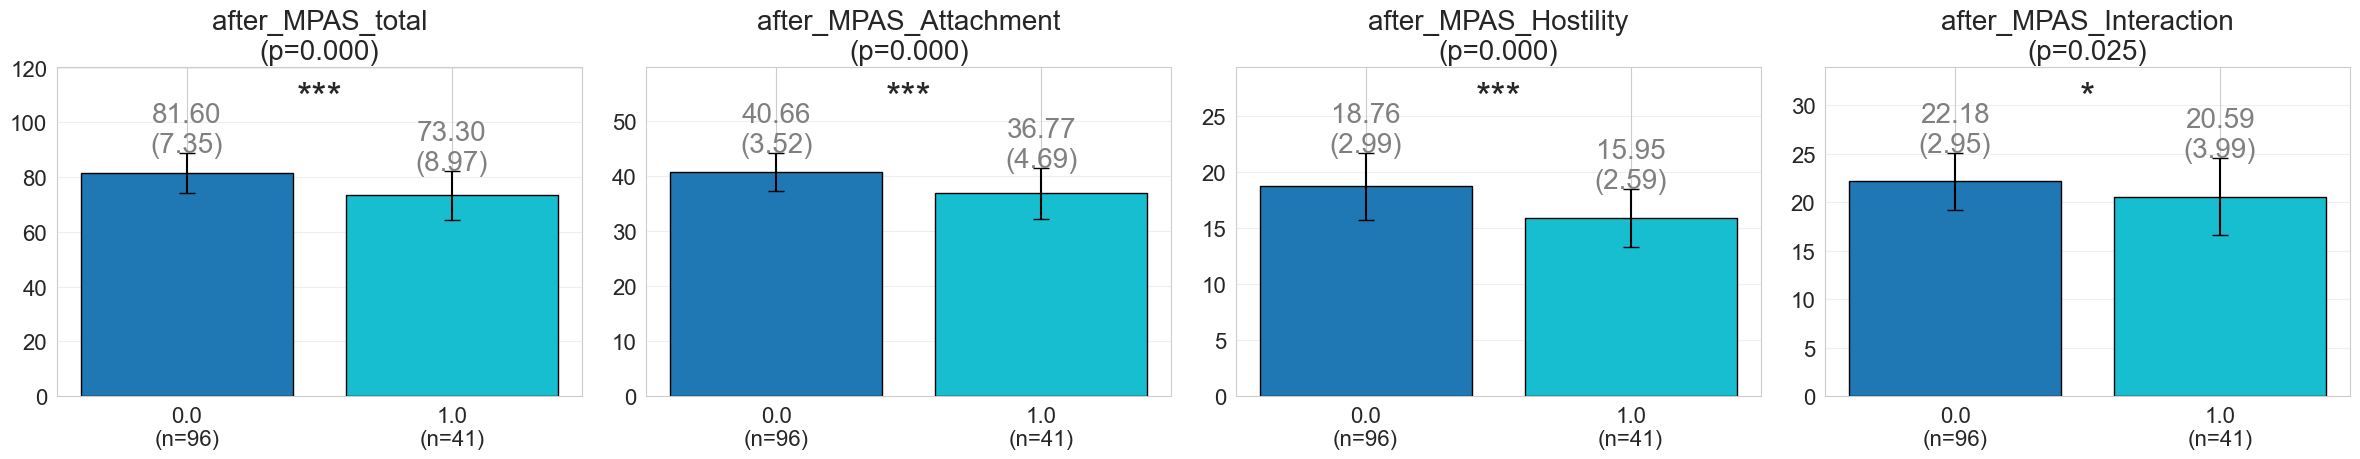

                 variable      mean0      std0  n0      mean1      std1  n1  \
0        after_MPAS_total  81.595833  7.350903  96  73.304878  8.966771  41   
1   after_MPAS_Attachment  40.661458  3.522450  96  36.770732  4.690482  41   
2    after_MPAS_Hostility  18.757292  2.987509  96  15.948780  2.589220  41   
3  after_MPAS_Interaction  22.177083  2.948665  96  20.585366  3.993592  41   

          p_raw stars  
0  2.076887e-06   ***  
1  1.222521e-05   ***  
2  3.126016e-07   ***  
3  2.506738e-02     *  


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import math

# --------------------------------------------------
# GLOBAL FONT SETTINGS – makes EVERYTHING bigger
# --------------------------------------------------
plt.rcParams.update({
    'font.size': 20,         # default font size
    'axes.titlesize': 20,    # subplot titles
    'axes.labelsize': 18,    # axis labels
    'xtick.labelsize': 16,   # x-axis ticks
    'ytick.labelsize': 16,   # y-axis ticks
})

# --------------------------------------------------
# 1. Load your data
# --------------------------------------------------
df = pd.read_csv("data/only_Q_outputs/combined/subjects_after_with_regression_clean.csv")

cluster_col = "cluster"

value_cols =  ['after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction']


# --------------------------------------------------
# 2. Clean variable names
# --------------------------------------------------
def clean_variable_name(var):
    """
    Example:
        after_DERS_total -> DERS
        after_DES_total  -> DES
    """
    parts = var.split("_")
    if len(parts) >= 3:
        return parts[1]  # the middle part
    return var


# --------------------------------------------------
# 3. Analysis & Plotting Function (NO FDR)
# --------------------------------------------------




# --------------------------------------------------
# 4. Run it
# --------------------------------------------------
results_df = compare_clusters_no_fdr(
    df,
    cluster_col=cluster_col,
    value_cols=value_cols
)

print(results_df)


## taking the dsta from after pregnancy and trying to compare the scores of the mpas and bits after pregnancy


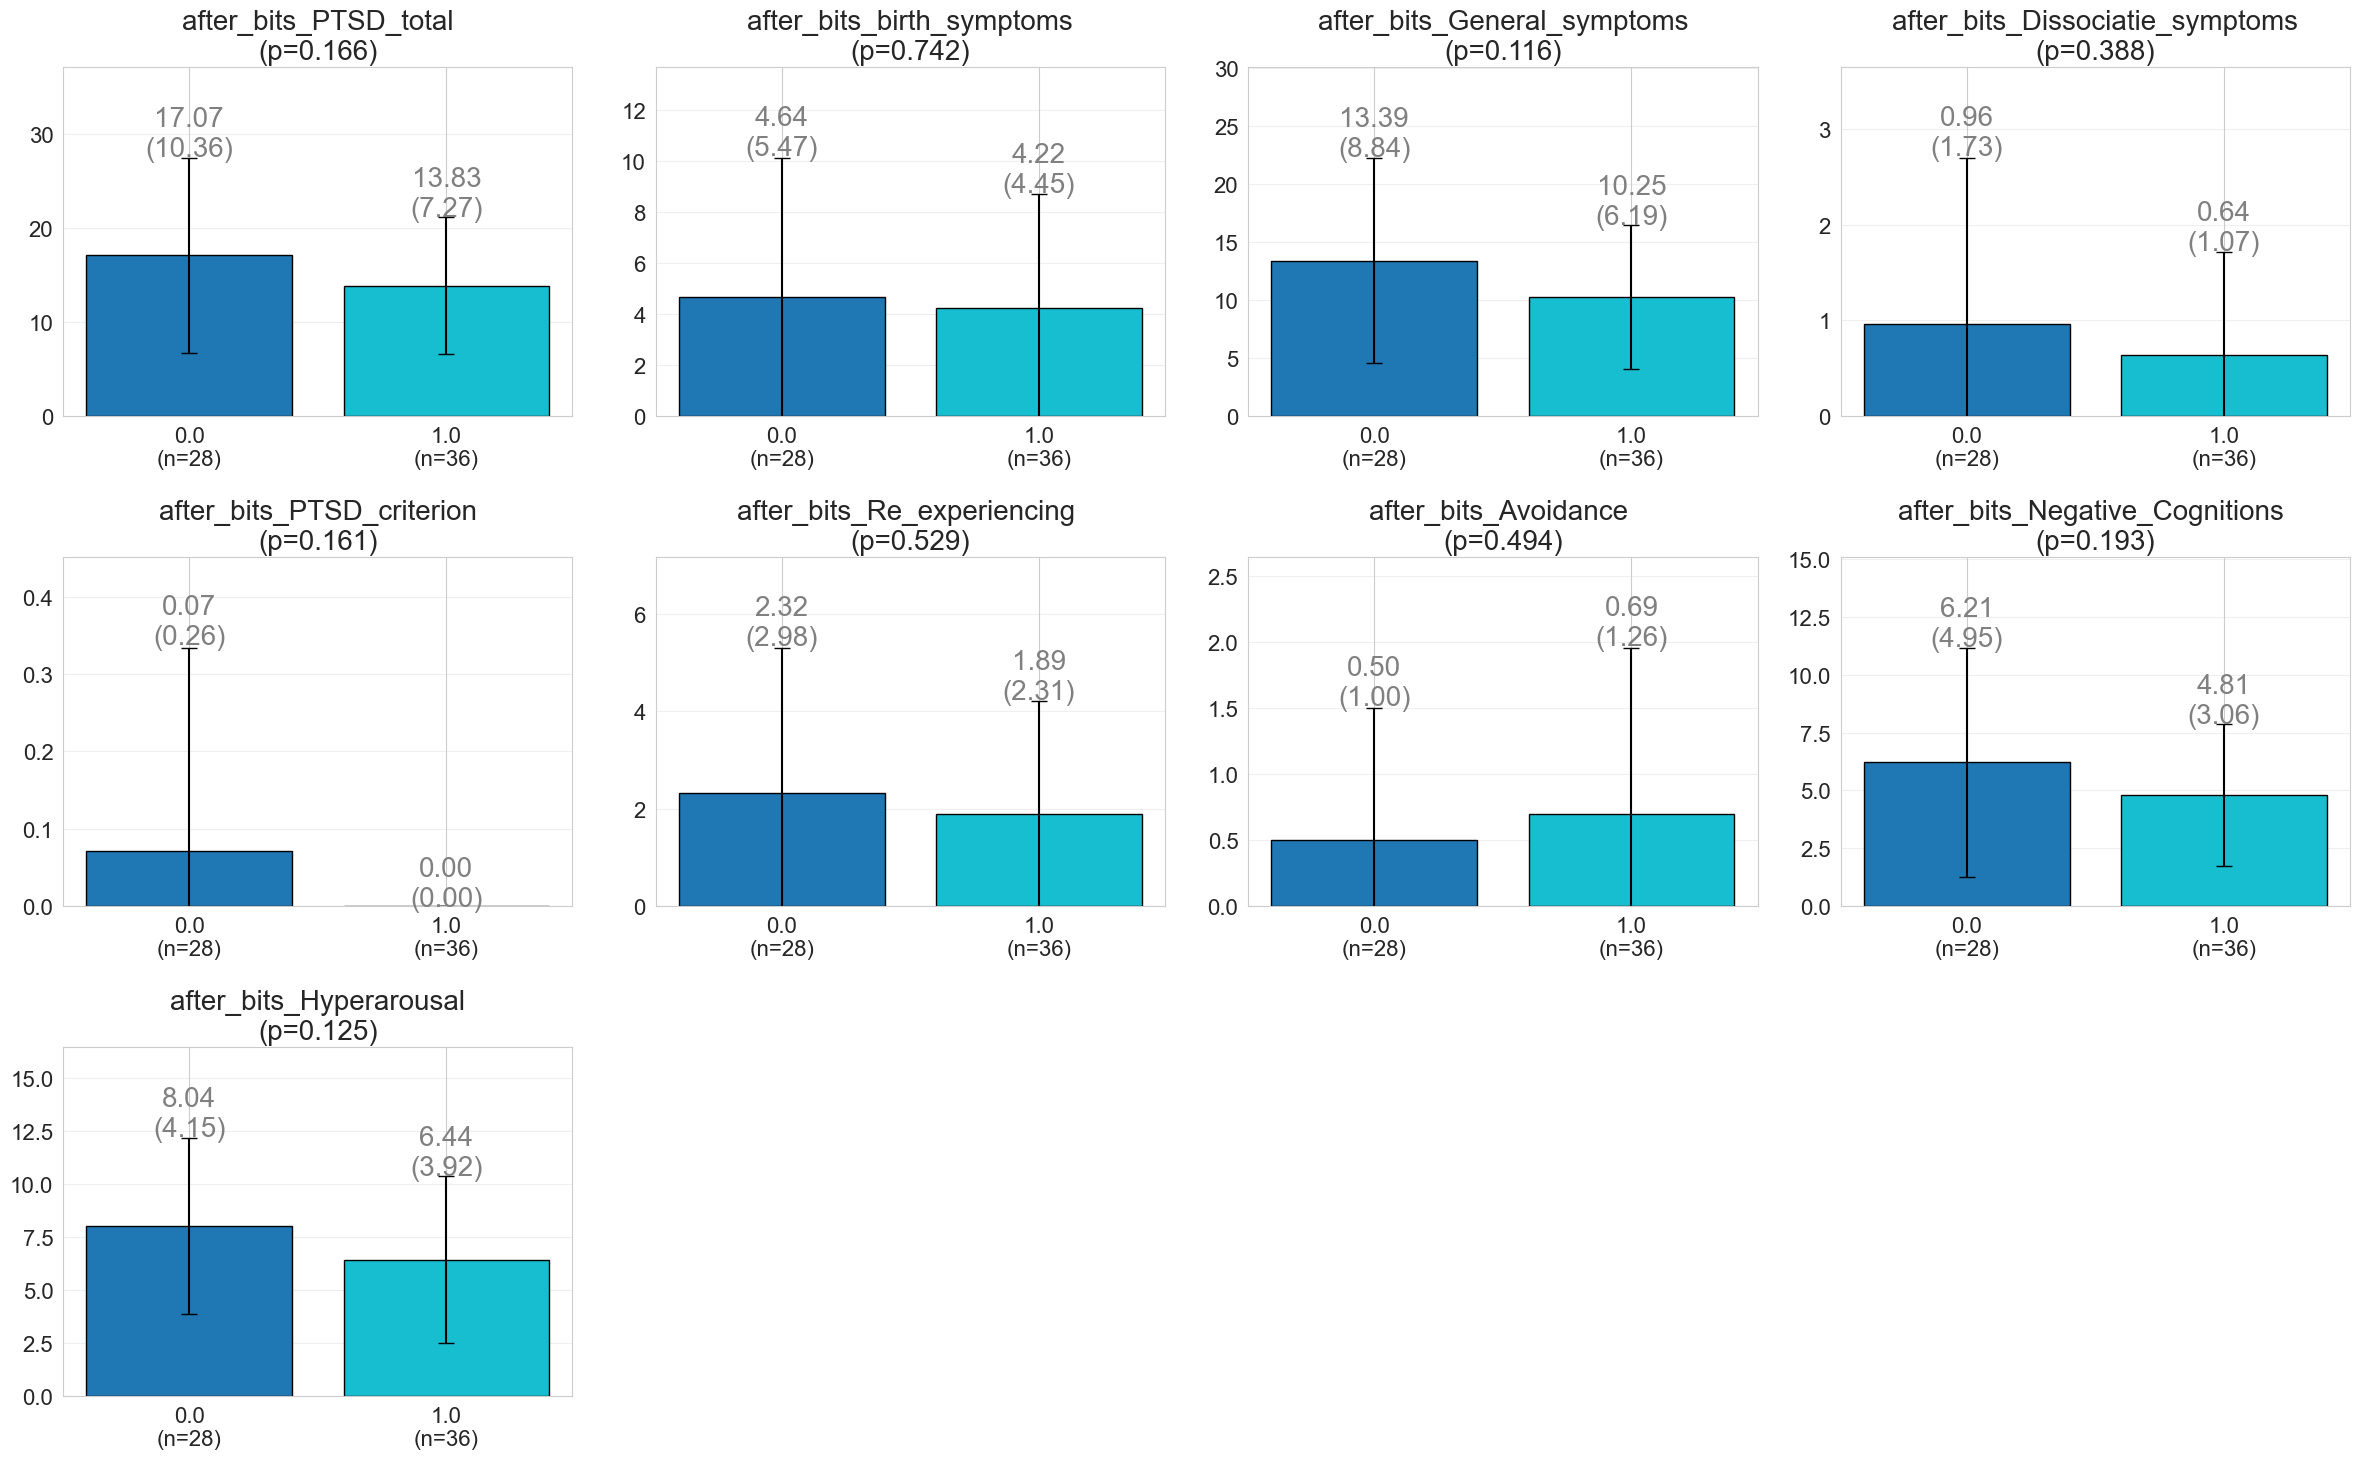

                          variable      mean0       std0  n0      mean1  \
0            after_bits_PTSD_total  17.071429  10.356349  28  13.833333   
1        after_bits_birth_symptoms   4.642857   5.465137  28   4.222222   
2      after_bits_General_symptoms  13.392857   8.841565  28  10.250000   
3  after_bits_Dissociatie_symptoms   0.964286   1.731669  28   0.638889   
4        after_bits_PTSD_criterion   0.071429   0.262265  28   0.000000   
5      after_bits_Re_experiencing    2.321429   2.982089  28   1.888889   
6            after_bits_Avoidance    0.500000   1.000000  28   0.694444   
7  after_bits_Negative_Cognitions    6.214286   4.946807  28   4.805556   
8          after_bits_Hyperarousal   8.035714   4.149807  28   6.444444   

       std1  n1     p_raw stars  
0  7.268327  36  0.166147        
1  4.453641  36  0.742198        
2  6.189276  36  0.116287        
3  1.073120  36  0.387817        
4  0.000000  36  0.161039        
5  2.314893  36  0.529425        
6  1.260826

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import math

# --------------------------------------------------
# GLOBAL FONT SETTINGS – makes EVERYTHING bigger
# --------------------------------------------------
plt.rcParams.update({
    'font.size': 20,         # default font size
    'axes.titlesize': 20,    # subplot titles
    'axes.labelsize': 18,    # axis labels
    'xtick.labelsize': 16,   # x-axis ticks
    'ytick.labelsize': 16,   # y-axis ticks
})

# --------------------------------------------------
# 1. Load your data
# --------------------------------------------------
df = pd.read_csv("data/only_Q_outputs/seperated/subjects_b_with_regression_clean.csv")

cluster_col = "cluster"

value_cols =  [ 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal']




# --------------------------------------------------
# 4. Run it
# --------------------------------------------------
results_df = compare_clusters_no_fdr(
    df,
    cluster_col=cluster_col,
    value_cols=value_cols
)

print(results_df)


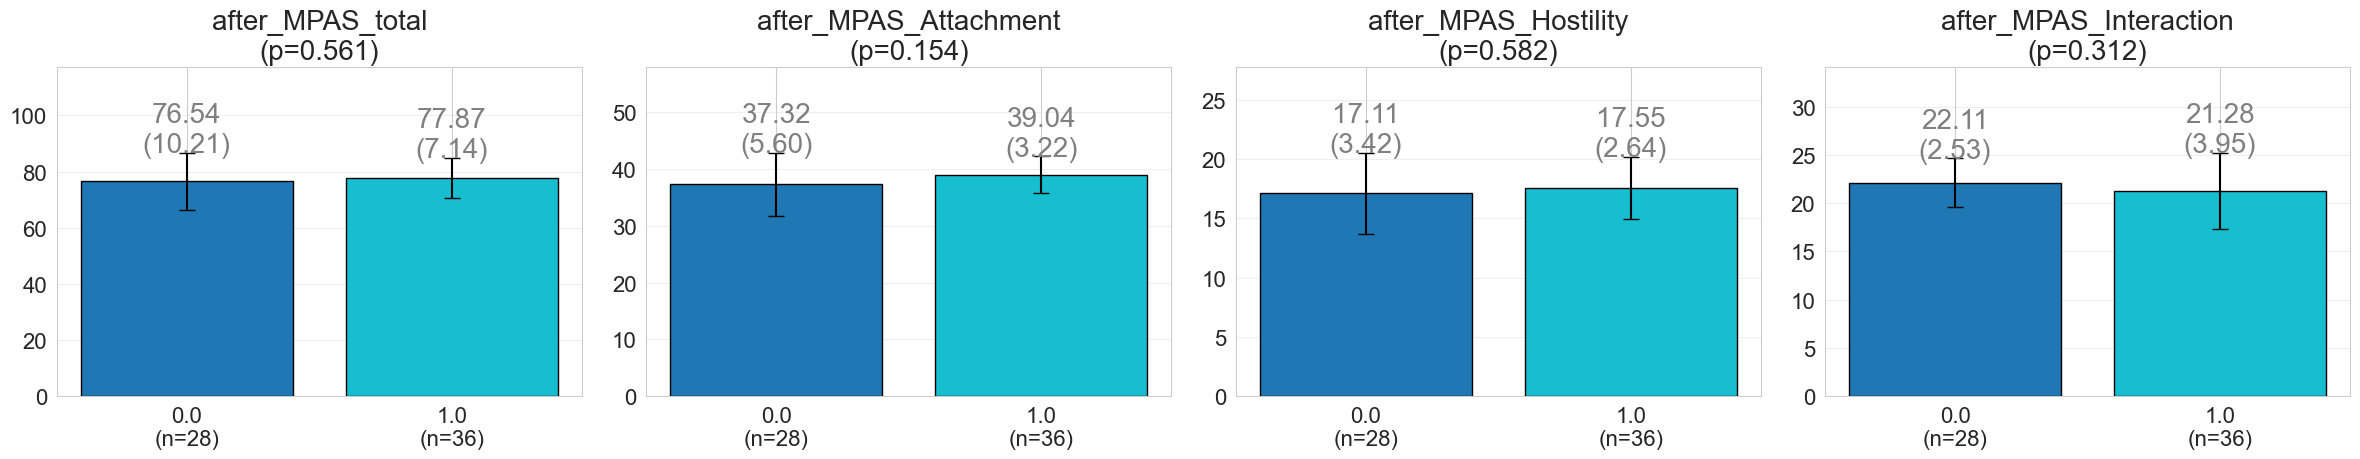

                 variable      mean0       std0  n0      mean1      std1  n1  \
0        after_MPAS_total  76.542857  10.211447  28  77.869444  7.135698  36   
1   after_MPAS_Attachment  37.321429   5.596319  28  39.044444  3.216781  36   
2    after_MPAS_Hostility  17.114286   3.416920  28  17.547222  2.638884  36   
3  after_MPAS_Interaction  22.107143   2.528933  28  21.277778  3.954102  36   

      p_raw stars  
0  0.561244        
1  0.153877        
2  0.581978        
3  0.312396        


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import math

# --------------------------------------------------
# GLOBAL FONT SETTINGS – makes EVERYTHING bigger
# --------------------------------------------------
plt.rcParams.update({
    'font.size': 20,         # default font size
    'axes.titlesize': 20,    # subplot titles
    'axes.labelsize': 18,    # axis labels
    'xtick.labelsize': 16,   # x-axis ticks
    'ytick.labelsize': 16,   # y-axis ticks
})

# --------------------------------------------------
# 1. Load your data
# --------------------------------------------------
df = pd.read_csv("data/only_Q_outputs/seperated/subjects_b_with_regression_clean.csv")

cluster_col = "cluster"

value_cols =  ['after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction']




# --------------------------------------------------
# 4. Run it
# --------------------------------------------------
results_df = compare_clusters_no_fdr(
    df,
    cluster_col=cluster_col,
    value_cols=value_cols
)

print(results_df)


## creating merged file for the clusters before the pregnancy + after the pregnancy

In [25]:
import pandas as pd

# -------------------------
# 1. Read before & after files
# -------------------------

before_path = r"data/only_Q_outputs/combined/subjects_b_with_regression_clean.csv"
after_path  = r"data/only_Q_outputs/combined/subjects_after_with_regression_clean.csv"

before_df = pd.read_csv(before_path)
after_df  = pd.read_csv(after_path)

# if your column is 'Subject_code' instead of 'Subject_Code', change here:
id_col = "Subject_Code"

# -------------------------
# 2. Rename cluster columns
# -------------------------

before_df = before_df.rename(columns={"cluster": "clusters_before"})
after_df  = after_df.rename(columns={"cluster": "clusters_after"})

# -------------------------
# 3. Full outer merge on Subject_Code
#    This keeps all subjects from both files
#    Regression columns with the same name get suffixes
# -------------------------

merged = pd.merge(
    before_df,
    after_df,
    on=id_col,
    how="outer",
    suffixes=("_beforefile", "_afterfile")
)

# At this point we have:
# Subject_Code, clusters_before, clusters_after,
# param1_beforefile, param1_afterfile, ...

# -------------------------
# 4. Collapse regression columns:
#    for each param, prefer "beforefile" value,
#    and if it's NaN, use "afterfile" value.
# -------------------------

# find all base regression names from the *_beforefile columns
reg_base_names = [
    col.replace("_beforefile", "")
    for col in merged.columns
    if col.endswith("_beforefile")
]

for base in reg_base_names:
    before_col = f"{base}_beforefile"
    after_col  = f"{base}_afterfile"

    # create a single clean column
    merged[base] = merged.get(before_col).combine_first(merged.get(after_col))

# drop the suffixed regression columns, keep only the clean ones
cols_to_drop = []
for base in reg_base_names:
    bcol = f"{base}_beforefile"
    acol = f"{base}_afterfile"
    if bcol in merged.columns:
        cols_to_drop.append(bcol)
    if acol in merged.columns:
        cols_to_drop.append(acol)

merged = merged.drop(columns=cols_to_drop)

# -------------------------
# 5. Optional: order columns nicely
# -------------------------

# put id + clusters first, then regression parameters
other_cols = [c for c in merged.columns if c not in [id_col, "clusters_before", "clusters_after"]]
merged = merged[[id_col, "clusters_before", "clusters_after"] + other_cols]

# -------------------------
# 6. Save final file
# -------------------------

out_path = r"data/only_Q_outputs/combined/clusters_regression_before_after.csv"
merged.to_csv(out_path, index=False)

print("Saved:", out_path)


Saved: data/only_Q_outputs/combined/clusters_regression_before_after.csv


## doing the cross prediction for the des

## creating merged ifile of the pca and the regression parameters

### BEFORE AND REGRESSION PARMETERS

In [58]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

pc_path = r"data/only_Q_outputs/seperated/pc1/before_data.csv"
regression_path = r"data/only_Q_outputs/seperated/regression_parameters_bits_mpas.csv"
clusters_path = r"data/only_Q_outputs/seperated/timepoints_file_inverted_2.csv"   # <-- ADD THIS

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)
cluster_df = pd.read_csv(clusters_path)   # reads clusters file

# -------------------------
# 2. Select regression columns
# -------------------------

regression_cols = ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction']

reg_sel = reg_df[regression_cols].copy()
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Select PC columns that contain the letter "b"
# -------------------------

# -------------------------
# 3. Select rows where timepoint contains "b" (case-insensitive)
# -------------------------

# keep rows where timepoint column contains "b"
pc_df_b = pc_df

# columns to keep:
#   - Subject_Code
#   - PC1 (all columns starting with PC1)
pc1_cols = ["Subject_Code"] +  ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12","PC13"]

pc_b = pc_df_b[pc1_cols].copy()


# Add PC1 manually

# -------------------------
# 4. Merge PC(b) with regression parameters
# -------------------------

merged = pd.merge(
    pc_b,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Add the cluster info
# -------------------------

# cluster_df contains columns like "before" and "after".
# Choose which cluster to merge (e.g., use "before")
cluster_col = "before"   # <--- change to "after" if you want after clusters

# keep only Subject_Code + chosen cluster
cluster_sel = cluster_df[["Subject_Code", cluster_col]].copy()
cluster_sel = cluster_sel.rename(columns={cluster_col: "cluster"})

# merge cluster into final merged dataset
merged = pd.merge(
    merged,
    cluster_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 6. Save result
# -------------------------

output_path = r"data/only_Q_outputs/seperated/subjects_pc_b_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)


Saved merged file:
 - data/only_Q_outputs/seperated/subjects_pc_b_with_regression.csv


In [59]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

pc_path = r"data/only_Q_outputs/seperated/pc1/after_data.csv"
regression_path = r"data/only_Q_outputs/seperated/regression_parameters_bits_mpas.csv"
clusters_path = r"data/only_Q_outputs/seperated/timepoints_file_inverted_2.csv"   # <-- ADD THIS

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)
cluster_df = pd.read_csv(clusters_path)   # reads clusters file

# -------------------------
# 2. Select regression columns
# -------------------------

regression_cols = ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction']

reg_sel = reg_df[regression_cols].copy()
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Select PC columns that contain the letter "b"
# -------------------------

# -------------------------
# 3. Select rows where timepoint contains "b" (case-insensitive)
# -------------------------

# keep rows where timepoint column contains "b"
pc_df_b = pc_df

# columns to keep:
#   - Subject_Code
#   - PC1 (all columns starting with PC1)
pc1_cols = ["Subject_Code"] +  ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11"]

pc_b = pc_df_b[pc1_cols].copy()


# Add PC1 manually

# -------------------------
# 4. Merge PC(b) with regression parameters
# -------------------------

merged = pd.merge(
    pc_b,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Add the cluster info
# -------------------------

# cluster_df contains columns like "before" and "after".
# Choose which cluster to merge (e.g., use "before")
cluster_col = "before"   # <--- change to "after" if you want after clusters

# keep only Subject_Code + chosen cluster
cluster_sel = cluster_df[["Subject_Code", cluster_col]].copy()
cluster_sel = cluster_sel.rename(columns={cluster_col: "cluster"})

# merge cluster into final merged dataset
merged = pd.merge(
    merged,
    cluster_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 6. Save result
# -------------------------

output_path = r"data/only_Q_outputs/seperated/subjects_pc_after_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)


Saved merged file:
 - data/only_Q_outputs/seperated/subjects_pc_after_with_regression.csv


### AFTER AND REGRESSION PARMETERS


## PREDICTING WITH LASSO AND PC'S

### with cv , predict bits using the before

Saved predictions: data/only_Q_outputs/seperated/subjects_b_predictions_with_r2.csv


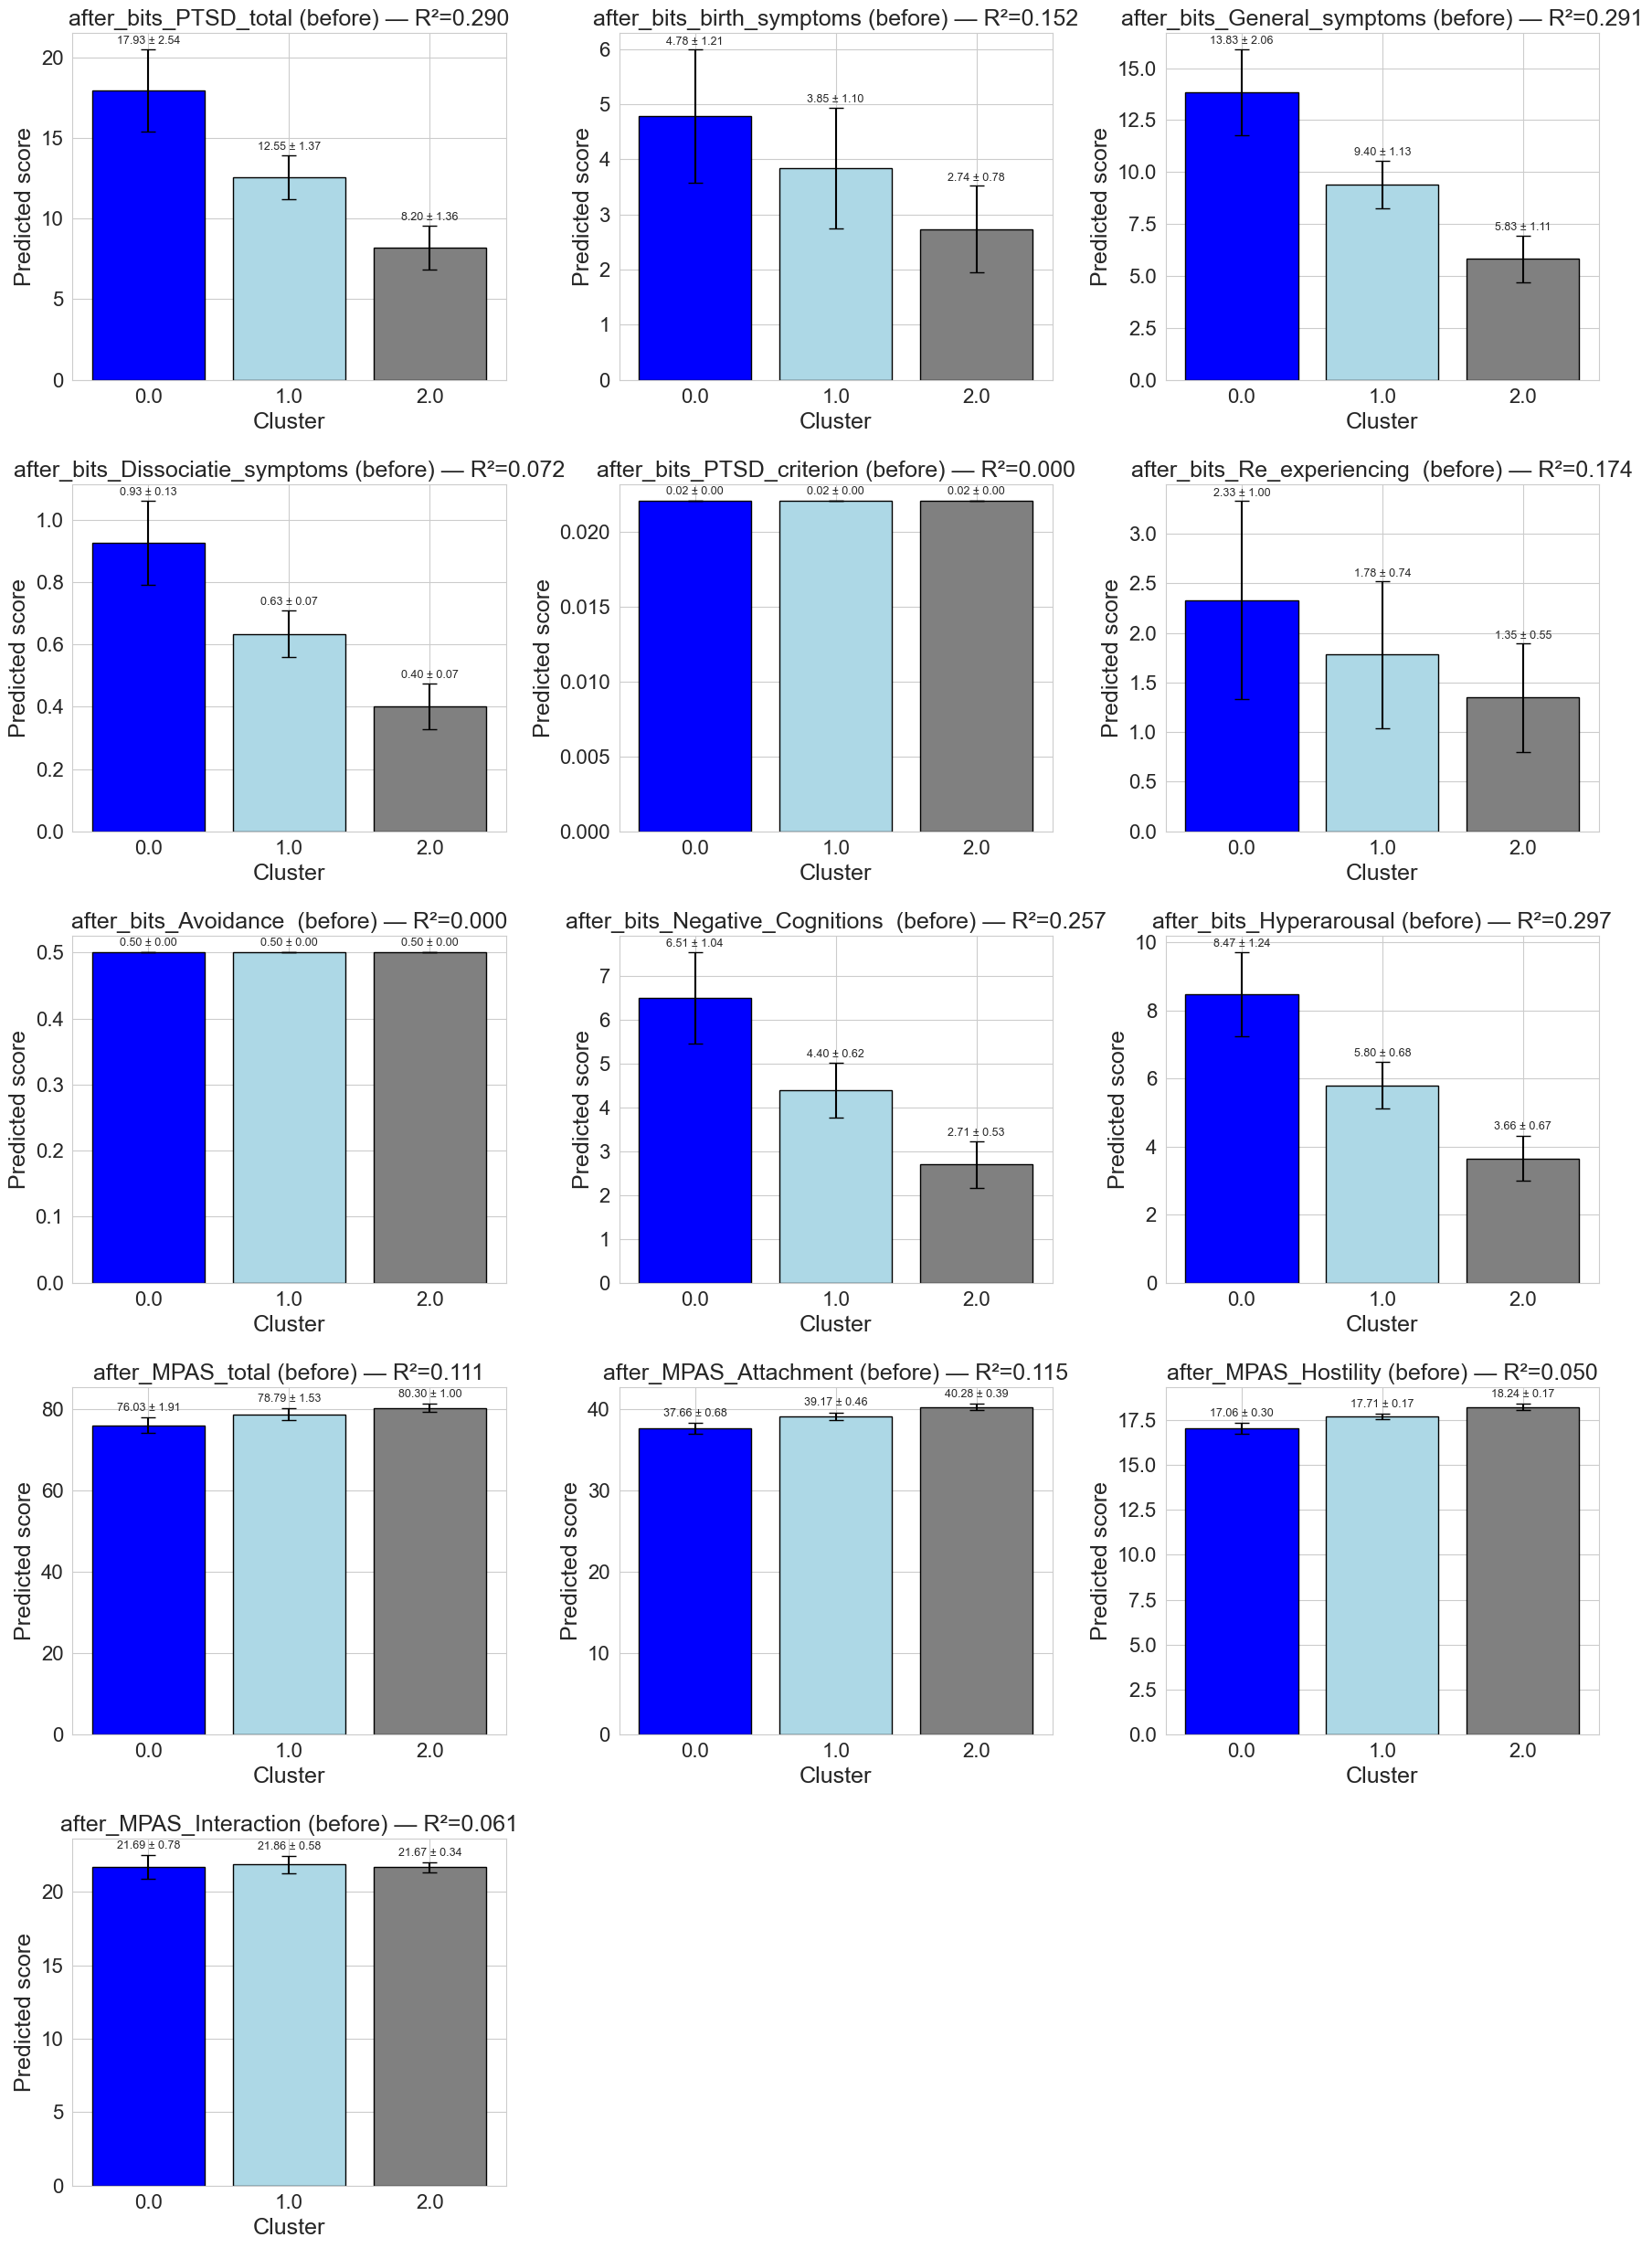

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV

# ------------------------------------------------------
# 1. Load DATA
# ------------------------------------------------------
data_path = r"data/only_Q_outputs/seperated/subjects_pc_b_with_regression.csv"
df = pd.read_csv(data_path)

# ------------------------------------------------------
# 2. Define PC columns and regression targets
# ------------------------------------------------------
pc_cols = [f"PC{i}" for i in range(1, 14)]

targets = [
    'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal',
    'after_MPAS_total', 'after_MPAS_Attachment',
    'after_MPAS_Hostility', 'after_MPAS_Interaction'
]

prediction_df = df[["Subject_Code", "cluster"]].copy()
results = {}

# ------------------------------------------------------
# 3. REGRESSION (LASSO CV)
# ------------------------------------------------------
for target in targets:

    valid_df = df[pc_cols + [target]].dropna()
    X = valid_df[pc_cols]
    y = valid_df[target]

    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X, y)

    # Predict on ALL rows
    preds = lasso.predict(df[pc_cols])

    prediction_df[f"pred_{target}"] = preds
    prediction_df[f"R2_{target}"] = lasso.score(X, y)

    results[target] = dict(
        alpha=lasso.alpha_,
        intercept=float(lasso.intercept_),
        R2=lasso.score(X, y),
        coefficients=list(map(float, lasso.coef_))
    )

# Save output
output_path = r"data/only_Q_outputs/seperated/subjects_b_predictions_with_r2.csv"
prediction_df.to_csv(output_path, index=False)
print("Saved predictions:", output_path)

# ------------------------------------------------------
# 4. PLOTTING — AUTO-GRID
# ------------------------------------------------------
df = prediction_df  # reuse the df with predictions
pred_cols = [c for c in df.columns if c.startswith("pred_")]
param_pairs = {pred: pred.replace("pred_", "R2_") for pred in pred_cols}

n_plots = len(pred_cols)
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

colors = {0: "blue", 1: "lightblue", "0": "blue", "1": "lightblue"}

for idx, pred_col in enumerate(pred_cols):
    ax = axes[idx]

    param_name = pred_col.replace("pred_", "")
    r2_col = param_pairs[pred_col]
    r2_value = df[r2_col].iloc[0]

    if param_name.startswith("b_"):
        timepoint = "before"
    elif param_name.startswith("after_"):
        timepoint = "after"
    else:
        timepoint = "unknown"

    # Group stats
    stats = df.groupby("cluster")[pred_col].agg(["mean", "std"])

    bar_colors = [colors.get(c, "gray") for c in stats.index]

    ax.bar(stats.index.astype(str), stats["mean"],
           yerr=stats["std"], capsize=6, color=bar_colors, edgecolor="black")

    ax.set_title(f"{param_name} (before) — R²={r2_value:.3f}", fontsize=18)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Predicted score")

    # Add mean ± std text
    for i, (cluster, row) in enumerate(stats.iterrows()):
        ax.text(
            i,
            row["mean"] + row["std"] + 0.02 * stats["mean"].max(),
            f"{row['mean']:.2f} ± {row['std']:.2f}",
            ha="center",
            fontsize=9
        )

# Hide empty axes
for i in range(len(pred_cols), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


## predicting MPAS using the before with cv

Saved predictions: data/only_Q_outputs/combined/subjects_b_predictions_with_r2.csv


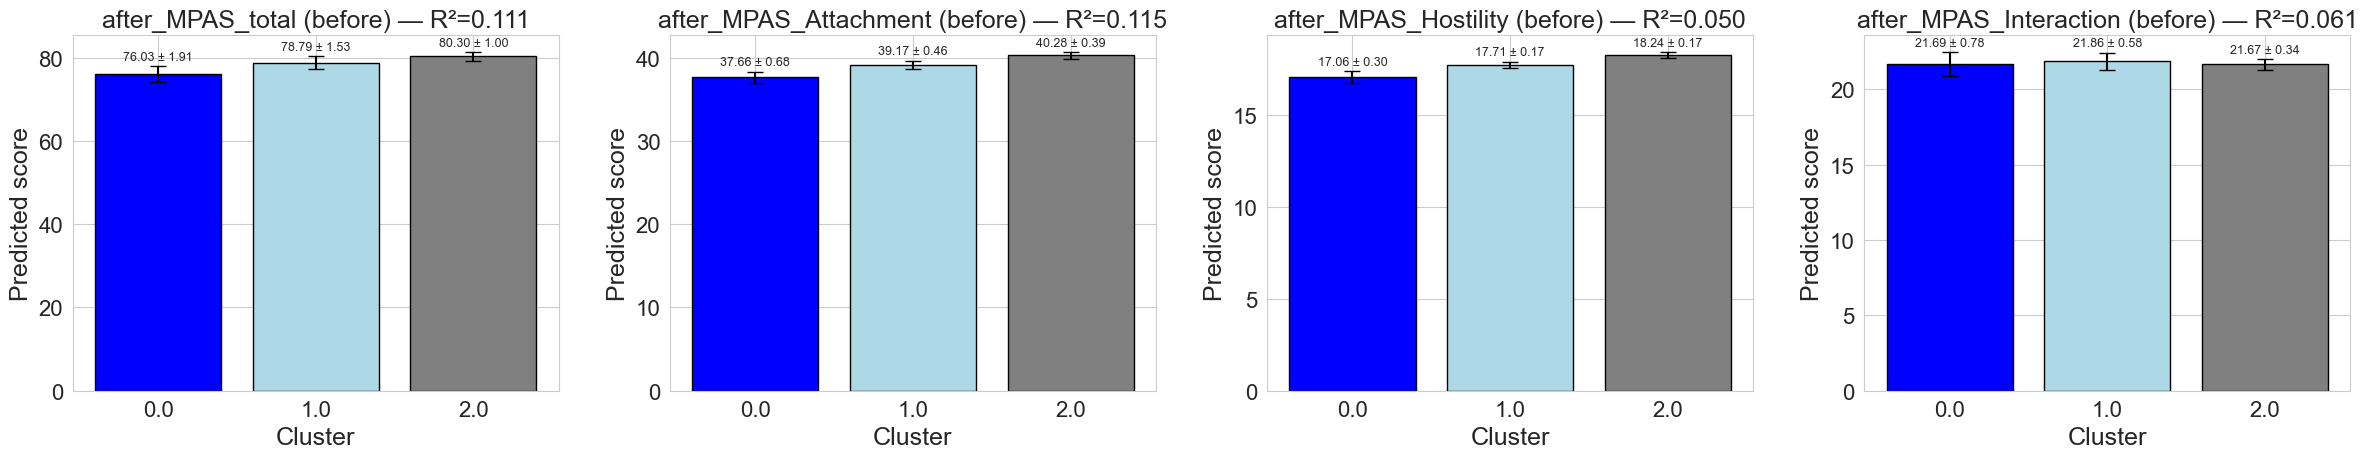

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV

# ------------------------------------------------------
# 1. Load DATA
# ------------------------------------------------------
data_path = r"data/only_Q_outputs/combined/subjects_pc_b_with_regression.csv"
df = pd.read_csv(data_path)

# ------------------------------------------------------
# 2. Define PC columns and regression targets
# ------------------------------------------------------
pc_cols = [f"PC{i}" for i in range(1, 14)]

targets = [

    'after_MPAS_total', 'after_MPAS_Attachment',
    'after_MPAS_Hostility', 'after_MPAS_Interaction'
]

prediction_df = df[["Subject_Code", "cluster"]].copy()
results = {}

# ------------------------------------------------------
# 3. REGRESSION (LASSO CV)
# ------------------------------------------------------
for target in targets:

    valid_df = df[pc_cols + [target]].dropna()
    X = valid_df[pc_cols]
    y = valid_df[target]

    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X, y)

    # Predict on ALL rows
    preds = lasso.predict(df[pc_cols])

    prediction_df[f"pred_{target}"] = preds
    prediction_df[f"R2_{target}"] = lasso.score(X, y)

    results[target] = dict(
        alpha=lasso.alpha_,
        intercept=float(lasso.intercept_),
        R2=lasso.score(X, y),
        coefficients=list(map(float, lasso.coef_))
    )

# Save output
output_path = r"data/only_Q_outputs/combined/subjects_b_predictions_with_r2.csv"
prediction_df.to_csv(output_path, index=False)
print("Saved predictions:", output_path)

# ------------------------------------------------------
# 4. PLOTTING — AUTO-GRID
# ------------------------------------------------------
df = prediction_df  # reuse the df with predictions
pred_cols = [c for c in df.columns if c.startswith("pred_")]
param_pairs = {pred: pred.replace("pred_", "R2_") for pred in pred_cols}

n_plots = len(pred_cols)
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

colors = {0: "blue", 1: "lightblue", "0": "blue", "1": "lightblue"}

for idx, pred_col in enumerate(pred_cols):
    ax = axes[idx]

    param_name = pred_col.replace("pred_", "")
    r2_col = param_pairs[pred_col]
    r2_value = df[r2_col].iloc[0]

    if param_name.startswith("b_"):
        timepoint = "before"
    elif param_name.startswith("after_"):
        timepoint = "after"
    else:
        timepoint = "unknown"

    # Group stats
    stats = df.groupby("cluster")[pred_col].agg(["mean", "std"])

    bar_colors = [colors.get(c, "gray") for c in stats.index]

    ax.bar(stats.index.astype(str), stats["mean"],
           yerr=stats["std"], capsize=6, color=bar_colors, edgecolor="black")

    ax.set_title(f"{param_name} (before) — R²={r2_value:.3f}", fontsize=18)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Predicted score")

    # Add mean ± std text
    for i, (cluster, row) in enumerate(stats.iterrows()):
        ax.text(
            i,
            row["mean"] + row["std"] + 0.02 * stats["mean"].max(),
            f"{row['mean']:.2f} ± {row['std']:.2f}",
            ha="center",
            fontsize=9
        )

# Hide empty axes
for i in range(len(pred_cols), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()
